In [32]:
# Imports and data load
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Try importing optional dependencies
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    xgboost_available = False
    print('  XGBoost not installed. Install with: pip install xgboost')

try:
    import optuna
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner
    optuna_available = True
except ImportError:
    optuna_available = False
    print('  Optuna not installed. Install with: pip install optuna')

# GPU support check
try:
    gpu_xgb_enabled = xgb.get_config()['gpu_id'] >= 0 if xgboost_available else False
except:
    gpu_xgb_enabled = False

ROOT = os.path.dirname(__file__) if '__file__' in globals() else '.'

os.path.exists(os.path.join(ROOT, 'engineered_features.xlsx'))
df = pd.read_excel(os.path.join(ROOT, 'engineered_features.xlsx'))
data_source = 'engineered_features.xlsx'

print('='*60)
print('Data Source:', data_source)
print('Dataset shape:', df.shape)
print('='*60)

Data Source: engineered_features.xlsx
Dataset shape: (3258, 34)


## Preprocessing
Prepare features and target `is_late`. Impute numeric columns, one-hot encode categoricals, and scale features.

In [33]:
# Prepare X and y with enhanced handling
TARGET = 'is_late'
if TARGET not in df.columns:
    raise SystemExit(f"Target '{TARGET}' not found in dataset")

y = df[TARGET].copy()
X = df.drop(columns=[TARGET])

# Encode target if categorical
if y.dtype == object or y.dtype.name == 'category':
    le = LabelEncoder()
    y = pd.Series(le.fit_transform(y.astype(str)), index=y.index)

print(f'Target variable distribution:')
print(pd.Series(y).value_counts())

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f'\nNumeric columns: {len(numeric_cols)}')
print(f'Categorical columns: {len(cat_cols)}')

# Impute numeric columns with median
if numeric_cols:
    X_num = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X[numeric_cols]), 
                         columns=numeric_cols, index=X.index)
else:
    X_num = pd.DataFrame(index=X.index)

# One-hot encode categorical columns
if cat_cols:
    X_cat = X[cat_cols].fillna('missing').astype(str)
    X_cat = pd.get_dummies(X_cat, drop_first=True)
else:
    X_cat = pd.DataFrame(index=X.index)

# Combine all features
X_proc = pd.concat([X_num, X_cat], axis=1).fillna(0)
print(f'\nFinal feature count: {X_proc.shape[1]}')
print(f'Total records: {X_proc.shape[0]}')

# Scale features using StandardScaler
scaler = StandardScaler().fit(X_proc)
X_scaled = scaler.transform(X_proc)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f'\nTrain set: {X_train.shape} | Test set: {X_test.shape}')
print(f'Train class distribution: {np.bincount(y_train)}')
print(f'Test class distribution: {np.bincount(y_test)}')

Target variable distribution:
is_late
0    1652
1    1606
Name: count, dtype: int64

Numeric columns: 2
Categorical columns: 31

Final feature count: 33
Total records: 3258

Train set: (2606, 33) | Test set: (652, 33)
Train class distribution: [1321 1285]
Test class distribution: [331 321]


## Model training and evaluation
Train Logistic Regression and Random Forest, evaluate F1 (binary), macro F1, accuracy, and show confusion matrix. Save the best model to `best_model.joblib`.

### Model definitions and tuning strategy
We'll tune each model with GridSearchCV using multi-metric scoring (`accuracy` and `f1_macro`) and set `refit='accuracy'` to prioritize accuracy improvements as requested. We also print cross-validated metrics for the chosen best estimators.

In [34]:
# Model pipelines and parameter grids (concise)
from sklearn.pipeline import Pipeline
pipe_log = Pipeline([('clf', LogisticRegression(max_iter=5000, class_weight='balanced', solver='liblinear'))])
param_grid_log = {'clf__C': [0.01, 0.1, 1, 10]}
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))])
param_grid_rf = {'clf__n_estimators': [100,200], 'clf__max_depth':[None,10,30]}
grids = {'logreg': (pipe_log, param_grid_log), 'rf': (pipe_rf, param_grid_rf)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'f1_macro':'f1_macro','f1_weighted':'f1_weighted'}
results = {}

### Run GridSearchCV per model (refit on accuracy)
This cell performs the grid search, fits the best estimator, calibrates probabilities, and records the test metrics.


LOGISTIC REGRESSION
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__C': 0.01, 'clf__penalty': 'l2'}
Best CV F1 (weighted): 0.6198

Test Metrics:
  Accuracy: 0.6518
  F1 (weighted): 0.6239
  F1 (macro): 0.6255
  ROC AUC: 0.7297
  PR AUC: 0.6758
  Best Threshold: 0.340


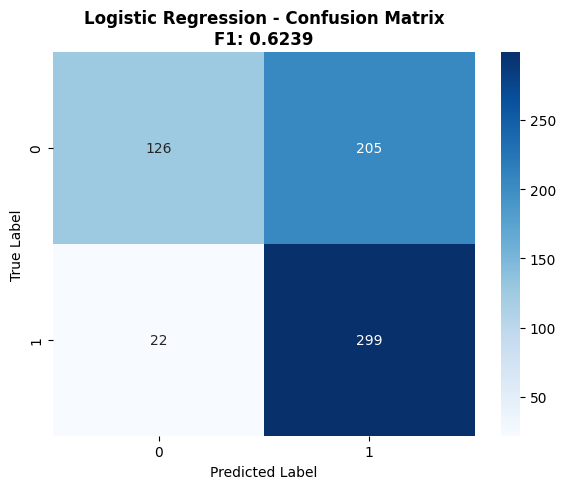


✓ Logistic Regression Complete


In [35]:
# Model 1: Logistic Regression with Enhanced Tuning
from sklearn.pipeline import Pipeline
print('\n' + '='*60)
print('LOGISTIC REGRESSION')
print('='*60)

pipe_log = Pipeline([('clf', LogisticRegression(max_iter=5000, class_weight='balanced', solver='saga'))])
param_grid_log = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2', 'l1']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'f1_macro': 'f1_macro', 'f1_weighted': 'f1_weighted', 'roc_auc': 'roc_auc', 'accuracy': 'accuracy'}

gs_log = GridSearchCV(pipe_log, param_grid_log, scoring=scoring, refit='f1_weighted', cv=cv, n_jobs=-1, verbose=1)
gs_log.fit(X_train, y_train)
best_log = gs_log.best_estimator_

print(f'Best params: {gs_log.best_params_}')
print(f'Best CV F1 (weighted): {gs_log.best_score_:.4f}')

# Calibrate probabilities
try:
    model_log = CalibratedClassifierCV(best_log, cv='prefit', method='sigmoid')
    model_log.fit(X_train, y_train)
except Exception as e:
    print(f'Calibration failed: {e}')
    model_log = best_log

# Get probabilities and optimize threshold
y_proba_log = model_log.predict_proba(X_test)[:, 1]
y_pred_log_default = (y_proba_log >= 0.5).astype(int)

# Find optimal threshold for F1
thresholds = np.linspace(0.01, 0.99, 99)
f1_scores_log = [f1_score(y_test, (y_proba_log >= t).astype(int)) for t in thresholds]
best_t_log = thresholds[int(np.argmax(f1_scores_log))]
y_pred_log = (y_proba_log >= best_t_log).astype(int)

# Calculate metrics
acc_log = accuracy_score(y_test, y_pred_log)
f1_weighted_log = f1_score(y_test, y_pred_log, average='weighted')
f1_macro_log = f1_score(y_test, y_pred_log, average='macro')
roc_auc_log = roc_auc_score(y_test, y_proba_log)
pr_auc_log = average_precision_score(y_test, y_proba_log)

results = {'logreg': {
    'model': model_log, 'best_params': gs_log.best_params_,
    'threshold': best_t_log, 'accuracy': acc_log, 'f1_weighted': f1_weighted_log,
    'f1_macro': f1_macro_log, 'roc_auc': roc_auc_log, 'pr_auc': pr_auc_log,
    'y_proba': y_proba_log, 'y_pred': y_pred_log
}}

print(f'\nTest Metrics:')
print(f'  Accuracy: {acc_log:.4f}')
print(f'  F1 (weighted): {f1_weighted_log:.4f}')
print(f'  F1 (macro): {f1_macro_log:.4f}')
print(f'  ROC AUC: {roc_auc_log:.4f}')
print(f'  PR AUC: {pr_auc_log:.4f}')
print(f'  Best Threshold: {best_t_log:.3f}')

cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Logistic Regression - Confusion Matrix\nF1: {f1_weighted_log:.4f}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print('\n✓ Logistic Regression Complete')

### Model 2: Random Forest


RANDOM FOREST
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best CV F1 (weighted): 0.6610

Test Metrics:
  Accuracy: 0.6887
  F1 (weighted): 0.6789
  F1 (macro): 0.6797
  ROC AUC: 0.7711
  PR AUC: 0.7160
  Best Threshold: 0.180


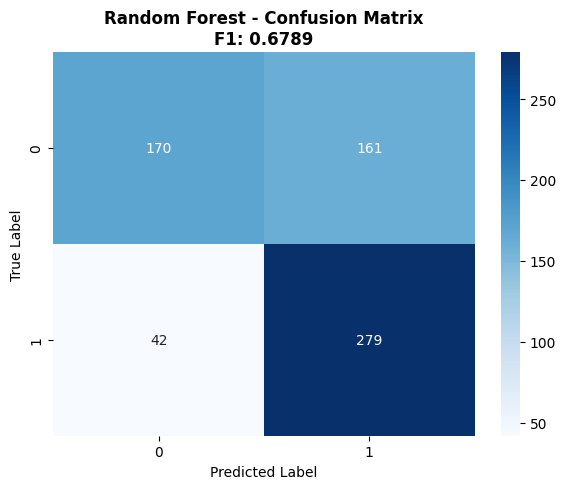


✓ Random Forest Complete


In [36]:
# Model 2: Random Forest with Enhanced Tuning
print('\n' + '='*60)
print('RANDOM FOREST')
print('='*60)

pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))])
param_grid_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [10, 20, 30, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring='f1_weighted', refit='f1_weighted', cv=cv, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_

print(f'Best params: {gs_rf.best_params_}')
print(f'Best CV F1 (weighted): {gs_rf.best_score_:.4f}')

# Calibrate probabilities
try:
    model_rf = CalibratedClassifierCV(best_rf, cv='prefit', method='sigmoid')
    model_rf.fit(X_train, y_train)
except Exception as e:
    print(f'Calibration failed: {e}')
    model_rf = best_rf

# Get probabilities and optimize threshold
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]
y_pred_rf_default = (y_proba_rf >= 0.5).astype(int)

# Find optimal threshold
thresholds = np.linspace(0.01, 0.99, 99)
f1_scores_rf = [f1_score(y_test, (y_proba_rf >= t).astype(int)) for t in thresholds]
best_t_rf = thresholds[int(np.argmax(f1_scores_rf))]
y_pred_rf = (y_proba_rf >= best_t_rf).astype(int)

# Calculate metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_weighted_rf = f1_score(y_test, y_pred_rf, average='weighted')
f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro')
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
pr_auc_rf = average_precision_score(y_test, y_proba_rf)

results['rf'] = {
    'model': model_rf, 'best_params': gs_rf.best_params_,
    'threshold': best_t_rf, 'accuracy': acc_rf, 'f1_weighted': f1_weighted_rf,
    'f1_macro': f1_macro_rf, 'roc_auc': roc_auc_rf, 'pr_auc': pr_auc_rf,
    'y_proba': y_proba_rf, 'y_pred': y_pred_rf
}

print(f'\nTest Metrics:')
print(f'  Accuracy: {acc_rf:.4f}')
print(f'  F1 (weighted): {f1_weighted_rf:.4f}')
print(f'  F1 (macro): {f1_macro_rf:.4f}')
print(f'  ROC AUC: {roc_auc_rf:.4f}')
print(f'  PR AUC: {pr_auc_rf:.4f}')
print(f'  Best Threshold: {best_t_rf:.3f}')

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Random Forest - Confusion Matrix\nF1: {f1_weighted_rf:.4f}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print('\n✓ Random Forest Complete')

### Select best model and save artifacts
Choose the model with highest test accuracy (default threshold) as final, save it and overall metrics.


EXTRA TREES
Test Metrics:
  Accuracy: 0.6794
  F1 (weighted): 0.6708
  F1 (macro): 0.6716
  ROC AUC: 0.7519
  PR AUC: 0.7008


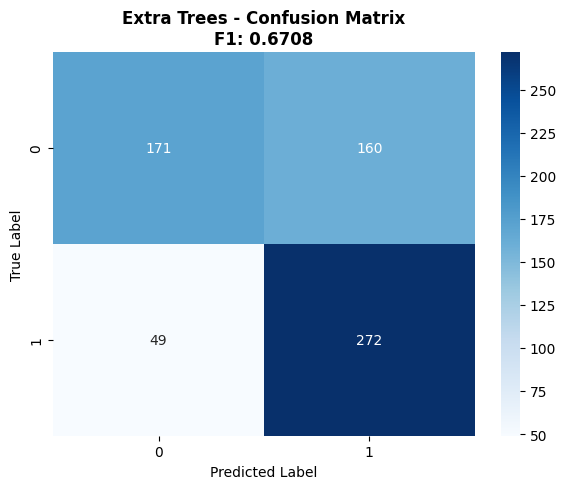


✓ Extra Trees Complete


In [37]:
# Model 4: Extra Trees with Enhanced Config
from sklearn.ensemble import ExtraTreesClassifier
print('\n' + '='*60)
print('EXTRA TREES')
print('='*60)

model_et = ExtraTreesClassifier(
    n_estimators=300, max_depth=20, min_samples_split=5,
    min_samples_leaf=2, class_weight='balanced', random_state=42, n_jobs=-1
)
model_et.fit(X_train, y_train)

# Calibrate
try:
    model_et = CalibratedClassifierCV(model_et, cv='prefit', method='sigmoid')
    model_et.fit(X_train, y_train)
except Exception as e:
    print(f'Calibration failed: {e}')

# Get predictions
y_proba_et = model_et.predict_proba(X_test)[:, 1]
f1_scores_et = [f1_score(y_test, (y_proba_et >= t).astype(int)) for t in thresholds]
best_t_et = thresholds[int(np.argmax(f1_scores_et))]
y_pred_et = (y_proba_et >= best_t_et).astype(int)

# Metrics
acc_et = accuracy_score(y_test, y_pred_et)
f1_weighted_et = f1_score(y_test, y_pred_et, average='weighted')
f1_macro_et = f1_score(y_test, y_pred_et, average='macro')
roc_auc_et = roc_auc_score(y_test, y_proba_et)
pr_auc_et = average_precision_score(y_test, y_proba_et)

results['et'] = {
    'model': model_et, 'threshold': best_t_et,
    'accuracy': acc_et, 'f1_weighted': f1_weighted_et, 'f1_macro': f1_macro_et,
    'roc_auc': roc_auc_et, 'pr_auc': pr_auc_et, 'y_proba': y_proba_et, 'y_pred': y_pred_et
}

print(f'Test Metrics:')
print(f'  Accuracy: {acc_et:.4f}')
print(f'  F1 (weighted): {f1_weighted_et:.4f}')
print(f'  F1 (macro): {f1_macro_et:.4f}')
print(f'  ROC AUC: {roc_auc_et:.4f}')
print(f'  PR AUC: {pr_auc_et:.4f}')

cm_et = confusion_matrix(y_test, y_pred_et)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_et, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Extra Trees - Confusion Matrix\nF1: {f1_weighted_et:.4f}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print('\n✓ Extra Trees Complete')


SUPPORT VECTOR MACHINE
Test Metrics:
  Accuracy: 0.6396
  F1 (weighted): 0.6195
  F1 (macro): 0.6208
  ROC AUC: 0.7091
  PR AUC: 0.6732


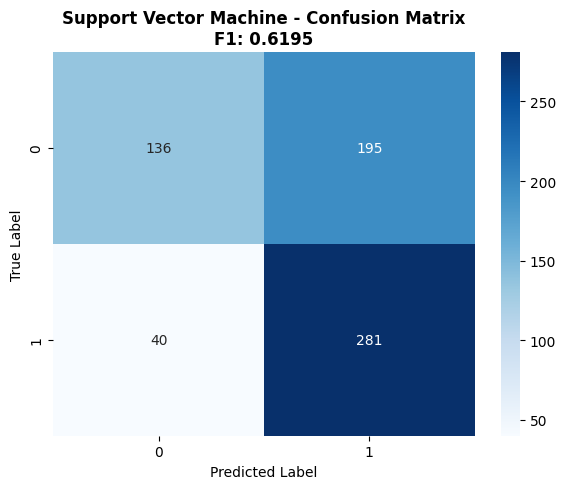


✓ SVM Complete


In [38]:
# Model 5: Support Vector Machine with Enhanced Config
from sklearn.svm import SVC
print('\n' + '='*60)
print('SUPPORT VECTOR MACHINE')
print('='*60)

model_svc = SVC(
    kernel='rbf', C=10, gamma='scale', probability=True,
    class_weight='balanced', random_state=42
)
model_svc.fit(X_train, y_train)

# Calibrate
try:
    model_svc = CalibratedClassifierCV(model_svc, cv='prefit', method='sigmoid')
    model_svc.fit(X_train, y_train)
except Exception as e:
    print(f'Calibration failed: {e}')

# Get predictions
y_proba_svc = model_svc.predict_proba(X_test)[:, 1]
f1_scores_svc = [f1_score(y_test, (y_proba_svc >= t).astype(int)) for t in thresholds]
best_t_svc = thresholds[int(np.argmax(f1_scores_svc))]
y_pred_svc = (y_proba_svc >= best_t_svc).astype(int)

# Metrics
acc_svc = accuracy_score(y_test, y_pred_svc)
f1_weighted_svc = f1_score(y_test, y_pred_svc, average='weighted')
f1_macro_svc = f1_score(y_test, y_pred_svc, average='macro')
roc_auc_svc = roc_auc_score(y_test, y_proba_svc)
pr_auc_svc = average_precision_score(y_test, y_proba_svc)

results['svc'] = {
    'model': model_svc, 'threshold': best_t_svc,
    'accuracy': acc_svc, 'f1_weighted': f1_weighted_svc, 'f1_macro': f1_macro_svc,
    'roc_auc': roc_auc_svc, 'pr_auc': pr_auc_svc, 'y_proba': y_proba_svc, 'y_pred': y_pred_svc
}

print(f'Test Metrics:')
print(f'  Accuracy: {acc_svc:.4f}')
print(f'  F1 (weighted): {f1_weighted_svc:.4f}')
print(f'  F1 (macro): {f1_macro_svc:.4f}')
print(f'  ROC AUC: {roc_auc_svc:.4f}')
print(f'  PR AUC: {pr_auc_svc:.4f}')

cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Support Vector Machine - Confusion Matrix\nF1: {f1_weighted_svc:.4f}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print('\n✓ SVM Complete')


K-NEAREST NEIGHBORS
Test Metrics:
  Accuracy: 0.5997
  F1 (weighted): 0.5556
  F1 (macro): 0.5577
  ROC AUC: 0.6922
  PR AUC: 0.6346


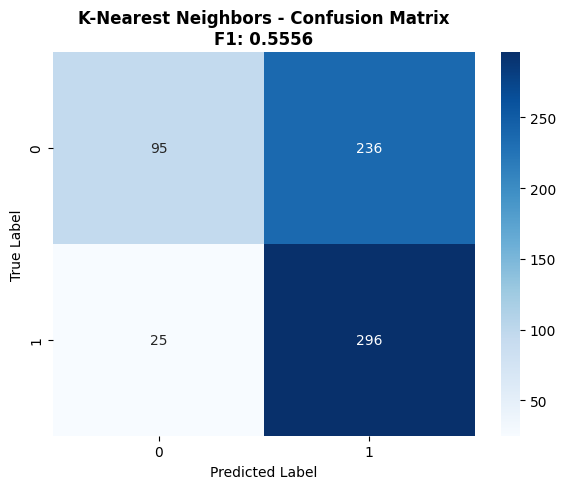


✓ KNN Complete


In [39]:
# Model 6: K-Nearest Neighbors with Optimized k
from sklearn.neighbors import KNeighborsClassifier
print('\n' + '='*60)
print('K-NEAREST NEIGHBORS')
print('='*60)

model_knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski', n_jobs=-1)
model_knn.fit(X_train, y_train)

# Calibrate
try:
    model_knn = CalibratedClassifierCV(model_knn, cv='prefit', method='sigmoid')
    model_knn.fit(X_train, y_train)
except Exception as e:
    print(f'Calibration failed: {e}')

# Get predictions
y_proba_knn = model_knn.predict_proba(X_test)[:, 1]
f1_scores_knn = [f1_score(y_test, (y_proba_knn >= t).astype(int)) for t in thresholds]
best_t_knn = thresholds[int(np.argmax(f1_scores_knn))]
y_pred_knn = (y_proba_knn >= best_t_knn).astype(int)

# Metrics
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_weighted_knn = f1_score(y_test, y_pred_knn, average='weighted')
f1_macro_knn = f1_score(y_test, y_pred_knn, average='macro')
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)
pr_auc_knn = average_precision_score(y_test, y_proba_knn)

results['knn'] = {
    'model': model_knn, 'threshold': best_t_knn,
    'accuracy': acc_knn, 'f1_weighted': f1_weighted_knn, 'f1_macro': f1_macro_knn,
    'roc_auc': roc_auc_knn, 'pr_auc': pr_auc_knn, 'y_proba': y_proba_knn, 'y_pred': y_pred_knn
}

print(f'Test Metrics:')
print(f'  Accuracy: {acc_knn:.4f}')
print(f'  F1 (weighted): {f1_weighted_knn:.4f}')
print(f'  F1 (macro): {f1_macro_knn:.4f}')
print(f'  ROC AUC: {roc_auc_knn:.4f}')
print(f'  PR AUC: {pr_auc_knn:.4f}')

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'K-Nearest Neighbors - Confusion Matrix\nF1: {f1_weighted_knn:.4f}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print('\n✓ KNN Complete')


ADABOOST
Test Metrics:
  Accuracy: 0.6626
  F1 (weighted): 0.6529
  F1 (macro): 0.6538
  ROC AUC: 0.7245
  PR AUC: 0.6777


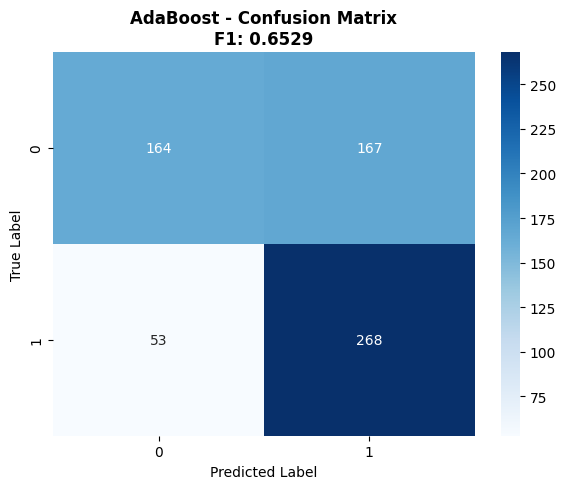


✓ AdaBoost Complete


In [40]:
# Model 7: AdaBoost with Enhanced Config
from sklearn.ensemble import AdaBoostClassifier
print('\n' + '='*60)
print('ADABOOST')
print('='*60)

model_ada = AdaBoostClassifier(
    n_estimators=200, learning_rate=0.8, random_state=42
)
model_ada.fit(X_train, y_train)

# Calibrate
try:
    model_ada = CalibratedClassifierCV(model_ada, cv='prefit', method='sigmoid')
    model_ada.fit(X_train, y_train)
except Exception as e:
    print(f'Calibration failed: {e}')

# Get predictions
y_proba_ada = model_ada.predict_proba(X_test)[:, 1]
f1_scores_ada = [f1_score(y_test, (y_proba_ada >= t).astype(int)) for t in thresholds]
best_t_ada = thresholds[int(np.argmax(f1_scores_ada))]
y_pred_ada = (y_proba_ada >= best_t_ada).astype(int)

# Metrics
acc_ada = accuracy_score(y_test, y_pred_ada)
f1_weighted_ada = f1_score(y_test, y_pred_ada, average='weighted')
f1_macro_ada = f1_score(y_test, y_pred_ada, average='macro')
roc_auc_ada = roc_auc_score(y_test, y_proba_ada)
pr_auc_ada = average_precision_score(y_test, y_proba_ada)

results['ada'] = {
    'model': model_ada, 'threshold': best_t_ada,
    'accuracy': acc_ada, 'f1_weighted': f1_weighted_ada, 'f1_macro': f1_macro_ada,
    'roc_auc': roc_auc_ada, 'pr_auc': pr_auc_ada, 'y_proba': y_proba_ada, 'y_pred': y_pred_ada
}

print(f'Test Metrics:')
print(f'  Accuracy: {acc_ada:.4f}')
print(f'  F1 (weighted): {f1_weighted_ada:.4f}')
print(f'  F1 (macro): {f1_macro_ada:.4f}')
print(f'  ROC AUC: {roc_auc_ada:.4f}')
print(f'  PR AUC: {pr_auc_ada:.4f}')

cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'AdaBoost - Confusion Matrix\nF1: {f1_weighted_ada:.4f}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print('\n✓ AdaBoost Complete')

[I 2026-02-21 13:50:07,859] A new study created in memory with name: xgb_optimization



Initializing Optuna study with TPE sampler...
Starting Optuna optimization (150 trials - this may take 5-10 minutes)...


Best trial: 0. Best value: 0.624966:   1%|          | 1/150 [00:02<06:21,  2.56s/it]

[I 2026-02-21 13:50:10,419] Trial 0 finished with value: 0.6249655553794722 and parameters: {'n_estimators': 250, 'max_depth': 15, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'min_child_weight': 1, 'gamma': 4.330880728874676, 'reg_alpha': 0.02537815508265665, 'reg_lambda': 0.06796578090758151}. Best is trial 0 with value: 0.6249655553794722.


Best trial: 0. Best value: 0.624966:   1%|▏         | 2/150 [00:04<05:18,  2.15s/it]

[I 2026-02-21 13:50:12,290] Trial 1 finished with value: 0.6182871634266636 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.11536162338241392, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'colsample_bylevel': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893, 'reg_alpha': 0.005342937261279773, 'reg_lambda': 0.0014618962793704966}. Best is trial 0 with value: 0.6249655553794722.


Best trial: 0. Best value: 0.624966:   2%|▏         | 3/150 [00:06<04:43,  1.93s/it]

[I 2026-02-21 13:50:13,951] Trial 2 finished with value: 0.61601853157326 and parameters: {'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.005292705365436975, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'colsample_bylevel': 0.8925879806965068, 'min_child_weight': 2, 'gamma': 2.571172192068058, 'reg_alpha': 0.0234238498471129, 'reg_lambda': 0.00015339162591163628}. Best is trial 0 with value: 0.6249655553794722.


Best trial: 0. Best value: 0.624966:   3%|▎         | 5/150 [00:06<02:02,  1.19it/s]

[I 2026-02-21 13:50:14,160] Trial 3 finished with value: 0.5930771962220772 and parameters: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.0014492412389916862, 'subsample': 0.9744427686266666, 'colsample_bytree': 0.9828160165372797, 'colsample_bylevel': 0.9041986740582306, 'min_child_weight': 4, 'gamma': 0.48836057003191935, 'reg_alpha': 0.054567254856014755, 'reg_lambda': 0.005762487216478602}. Best is trial 0 with value: 0.6249655553794722.
[I 2026-02-21 13:50:14,283] Trial 4 finished with value: 0.5882370202348642 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.0012167028814593455, 'subsample': 0.954660201039391, 'colsample_bytree': 0.6293899908000085, 'colsample_bylevel': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054, 'reg_alpha': 0.015375920235481757, 'reg_lambda': 0.0005488047000766049}. Best is trial 0 with value: 0.6249655553794722.


Best trial: 0. Best value: 0.624966:   5%|▍         | 7/150 [00:06<01:04,  2.23it/s]

[I 2026-02-21 13:50:14,457] Trial 5 finished with value: 0.6171926135160574 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.21244807336152005, 'subsample': 0.9474136752138245, 'colsample_bytree': 0.7989499894055425, 'colsample_bylevel': 0.9609371175115584, 'min_child_weight': 1, 'gamma': 0.979914312095726, 'reg_alpha': 0.00015167330688076205, 'reg_lambda': 0.0020013420622879987}. Best is trial 0 with value: 0.6249655553794722.
[I 2026-02-21 13:50:14,560] Trial 6 finished with value: 0.622729876241015 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.11294923622078903, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904, 'colsample_bylevel': 0.7713480415791243, 'min_child_weight': 2, 'gamma': 4.010984903770199, 'reg_alpha': 0.00019870215385428647, 'reg_lambda': 0.8862326508576243}. Best is trial 0 with value: 0.6249655553794722.


Best trial: 0. Best value: 0.624966:   5%|▌         | 8/150 [00:07<00:53,  2.67it/s]

[I 2026-02-21 13:50:14,778] Trial 7 finished with value: 0.593125221710952 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.0010319982330247674, 'subsample': 0.9077307142274171, 'colsample_bytree': 0.8534286719238086, 'colsample_bylevel': 0.8645035840204937, 'min_child_weight': 8, 'gamma': 0.3702232586704518, 'reg_alpha': 0.00271558195528294, 'reg_lambda': 0.00029072088906598463}. Best is trial 0 with value: 0.6249655553794722.
[I 2026-02-21 13:50:14,964] Trial 8 finished with value: 0.6114090238429931 and parameters: {'n_estimators': 450, 'max_depth': 11, 'learning_rate': 0.006601984958164864, 'subsample': 0.5317791751430119, 'colsample_bytree': 0.6554911608578311, 'colsample_bylevel': 0.6625916610133735, 'min_child_weight': 8, 'gamma': 3.1877873567760657, 'reg_alpha': 0.35387588647792356, 'reg_lambda': 0.007742116473996248}. Best is trial 0 with value: 0.6249655553794722.


Best trial: 9. Best value: 0.631775:   7%|▋         | 11/150 [00:07<00:28,  4.83it/s]

[I 2026-02-21 13:50:15,055] Trial 9 finished with value: 0.6317747506272575 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.07665788170871725, 'subsample': 0.7806385987847482, 'colsample_bytree': 0.8854835899772805, 'colsample_bylevel': 0.7468977981821954, 'min_child_weight': 6, 'gamma': 2.137705091792748, 'reg_alpha': 0.00012637946338082883, 'reg_lambda': 0.00027012557725439106}. Best is trial 9 with value: 0.6317747506272575.
[I 2026-02-21 13:50:15,135] Trial 10 finished with value: 0.6095448655559775 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.00600755675334899, 'subsample': 0.7542853455823514, 'colsample_bytree': 0.9537832369630466, 'colsample_bylevel': 0.6246461145744375, 'min_child_weight': 5, 'gamma': 3.7777556927152434, 'reg_alpha': 0.0008226074946221043, 'reg_lambda': 0.0002031980983842498}. Best is trial 9 with value: 0.6317747506272575.
[I 2026-02-21 13:50:15,225] Trial 11 finished with value: 0.6240288162372074 and par

Best trial: 9. Best value: 0.631775:   9%|▉         | 14/150 [00:07<00:23,  5.87it/s]

[I 2026-02-21 13:50:15,420] Trial 12 finished with value: 0.6026256591751175 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.0061338502201741816, 'subsample': 0.5550259622638384, 'colsample_bytree': 0.6139675812709708, 'colsample_bylevel': 0.7135538943131281, 'min_child_weight': 9, 'gamma': 4.303652916281717, 'reg_alpha': 0.00010661259689433907, 'reg_lambda': 0.01104051190316225}. Best is trial 9 with value: 0.6317747506272575.
[I 2026-02-21 13:50:15,554] Trial 13 finished with value: 0.5949595099517233 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0019811668345619416, 'subsample': 0.668807585701814, 'colsample_bytree': 0.9714548519562596, 'colsample_bylevel': 0.6616014660103776, 'min_child_weight': 6, 'gamma': 3.515094794475889, 'reg_alpha': 0.0028478585168562965, 'reg_lambda': 0.7711312991331102}. Best is trial 9 with value: 0.6317747506272575.


Best trial: 9. Best value: 0.631775:  10%|█         | 15/150 [00:07<00:24,  5.58it/s]

[I 2026-02-21 13:50:15,760] Trial 14 finished with value: 0.6220996067221732 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01705080323979002, 'subsample': 0.6504391549083848, 'colsample_bytree': 0.6424202471887338, 'colsample_bylevel': 0.5184434736772664, 'min_child_weight': 7, 'gamma': 2.5133951161443076, 'reg_alpha': 0.0001606626792172772, 'reg_lambda': 0.0013019246714361576}. Best is trial 9 with value: 0.6317747506272575.


Best trial: 9. Best value: 0.631775:  11%|█▏        | 17/150 [00:08<00:25,  5.29it/s]

[I 2026-02-21 13:50:15,997] Trial 15 finished with value: 0.603670753295528 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.0022851892235553474, 'subsample': 0.7447263801387816, 'colsample_bytree': 0.9928252270553004, 'colsample_bylevel': 0.6210276357557503, 'min_child_weight': 7, 'gamma': 3.8080980766435877, 'reg_alpha': 0.0008923807143379785, 'reg_lambda': 0.08182111518618412}. Best is trial 9 with value: 0.6317747506272575.
[I 2026-02-21 13:50:16,173] Trial 16 finished with value: 0.6291538982149838 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.037096241656107316, 'subsample': 0.7678873420373793, 'colsample_bytree': 0.5451448850272042, 'colsample_bylevel': 0.917651247794619, 'min_child_weight': 4, 'gamma': 0.9325925519992712, 'reg_alpha': 0.00014557961490251997, 'reg_lambda': 0.023097861492693564}. Best is trial 9 with value: 0.6317747506272575.


Best trial: 9. Best value: 0.631775:  13%|█▎        | 19/150 [00:08<00:21,  6.07it/s]

[I 2026-02-21 13:50:16,364] Trial 17 finished with value: 0.6192344732490566 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.018557377359658574, 'subsample': 0.613247887598969, 'colsample_bytree': 0.822586395204725, 'colsample_bylevel': 0.5871832145024958, 'min_child_weight': 7, 'gamma': 1.933676731502687, 'reg_alpha': 0.5583672722754817, 'reg_lambda': 0.0003548818403010948}. Best is trial 9 with value: 0.6317747506272575.
[I 2026-02-21 13:50:16,466] Trial 18 finished with value: 0.6061095457665024 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.19524423350212713, 'subsample': 0.9386696766904905, 'colsample_bytree': 0.6289708138575778, 'colsample_bylevel': 0.8299920230170895, 'min_child_weight': 9, 'gamma': 2.7760040579973118, 'reg_alpha': 0.013140210226207382, 'reg_lambda': 0.0009277034327414725}. Best is trial 9 with value: 0.6317747506272575.
[I 2026-02-21 13:50:16,526] Trial 19 finished with value: 0.5988132301861275 and parameters:

Best trial: 9. Best value: 0.631775:  15%|█▍        | 22/150 [00:08<00:17,  7.45it/s]

[I 2026-02-21 13:50:16,666] Trial 20 finished with value: 0.6301839839296172 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.03356351453276522, 'subsample': 0.8347234902624482, 'colsample_bytree': 0.8876463479158987, 'colsample_bylevel': 0.7507103134267252, 'min_child_weight': 5, 'gamma': 1.7948135561336622, 'reg_alpha': 0.0005081804508106705, 'reg_lambda': 0.0375708435875315}. Best is trial 9 with value: 0.6317747506272575.
[I 2026-02-21 13:50:16,795] Trial 21 finished with value: 0.6175860379447672 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.04606067503270245, 'subsample': 0.8374499208573541, 'colsample_bytree': 0.5155351548865419, 'colsample_bylevel': 0.7662796225799471, 'min_child_weight': 5, 'gamma': 1.7523695599914384, 'reg_alpha': 0.0004942001887539527, 'reg_lambda': 0.03128588311291136}. Best is trial 9 with value: 0.6317747506272575.


Best trial: 9. Best value: 0.631775:  16%|█▌        | 24/150 [00:09<00:17,  7.05it/s]

[I 2026-02-21 13:50:16,940] Trial 22 finished with value: 0.6303705822837372 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.03226634795134044, 'subsample': 0.862959841414223, 'colsample_bytree': 0.8891900703372412, 'colsample_bylevel': 0.9948672027559254, 'min_child_weight': 3, 'gamma': 1.7492773094045992, 'reg_alpha': 0.0003720996902948259, 'reg_lambda': 0.21413683157337213}. Best is trial 9 with value: 0.6317747506272575.
[I 2026-02-21 13:50:17,096] Trial 23 finished with value: 0.6314906773520265 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.023745797086645856, 'subsample': 0.8650099886774185, 'colsample_bytree': 0.9047894591765571, 'colsample_bylevel': 0.9990152269470942, 'min_child_weight': 3, 'gamma': 1.8614927848177827, 'reg_alpha': 0.0004365418910259183, 'reg_lambda': 0.3299557544633791}. Best is trial 9 with value: 0.6317747506272575.


Best trial: 24. Best value: 0.632275:  17%|█▋        | 25/150 [00:09<00:19,  6.38it/s]

[I 2026-02-21 13:50:17,291] Trial 24 finished with value: 0.6322752404628442 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.015928401790160137, 'subsample': 0.8687718921235604, 'colsample_bytree': 0.909226268197376, 'colsample_bylevel': 0.9930688369518195, 'min_child_weight': 3, 'gamma': 1.4627790591685583, 'reg_alpha': 0.0003864916737803517, 'reg_lambda': 0.2860693981486929}. Best is trial 24 with value: 0.6322752404628442.


Best trial: 24. Best value: 0.632275:  18%|█▊        | 27/150 [00:09<00:19,  6.30it/s]

[I 2026-02-21 13:50:17,478] Trial 25 finished with value: 0.6274367898946717 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.015379854730658806, 'subsample': 0.8853032397382125, 'colsample_bytree': 0.9259626213688477, 'colsample_bylevel': 0.9630103794637368, 'min_child_weight': 3, 'gamma': 1.3961332637278563, 'reg_alpha': 0.002050884892193022, 'reg_lambda': 0.3557114814711279}. Best is trial 24 with value: 0.6322752404628442.
[I 2026-02-21 13:50:17,620] Trial 26 finished with value: 0.6213462447451752 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.012406823358638753, 'subsample': 0.7166923763186818, 'colsample_bytree': 0.7614207071565826, 'colsample_bylevel': 0.8083904250626514, 'min_child_weight': 3, 'gamma': 2.155739727112454, 'reg_alpha': 0.0011932328630087842, 'reg_lambda': 0.0030196879449869325}. Best is trial 24 with value: 0.6322752404628442.


Best trial: 24. Best value: 0.632275:  19%|█▊        | 28/150 [00:09<00:18,  6.49it/s]

[I 2026-02-21 13:50:17,763] Trial 27 finished with value: 0.6295786229629207 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.06427733175266159, 'subsample': 0.7850682526106738, 'colsample_bytree': 0.9179305119320693, 'colsample_bylevel': 0.9899758310268613, 'min_child_weight': 6, 'gamma': 1.2543957347004575, 'reg_alpha': 0.0002833148955383085, 'reg_lambda': 0.378136552113353}. Best is trial 24 with value: 0.6322752404628442.


Best trial: 24. Best value: 0.632275:  21%|██        | 31/150 [00:10<00:16,  7.37it/s]

[I 2026-02-21 13:50:18,020] Trial 28 finished with value: 0.6248477998005287 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.010445583919824926, 'subsample': 0.870221065998578, 'colsample_bytree': 0.8800521981556457, 'colsample_bylevel': 0.8674835392178326, 'min_child_weight': 2, 'gamma': 2.180724089568984, 'reg_alpha': 0.006525925972269257, 'reg_lambda': 0.38864218707484477}. Best is trial 24 with value: 0.6322752404628442.
[I 2026-02-21 13:50:18,089] Trial 29 finished with value: 0.6086673229260299 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.07842339865594306, 'subsample': 0.8029423301406536, 'colsample_bytree': 0.9207183226546717, 'colsample_bylevel': 0.7045005355351618, 'min_child_weight': 1, 'gamma': 4.906565433791466, 'reg_alpha': 0.07359974431492602, 'reg_lambda': 0.06111431963400507}. Best is trial 24 with value: 0.6322752404628442.
[I 2026-02-21 13:50:18,177] Trial 30 finished with value: 0.6075073777281158 and parameters

Best trial: 31. Best value: 0.632525:  22%|██▏       | 33/150 [00:10<00:15,  7.32it/s]

[I 2026-02-21 13:50:18,338] Trial 31 finished with value: 0.6325246265519093 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.02516177101641949, 'subsample': 0.8589086603441745, 'colsample_bytree': 0.8831531597551295, 'colsample_bylevel': 0.9987349142404867, 'min_child_weight': 3, 'gamma': 1.507043693848418, 'reg_alpha': 0.0004301093406576303, 'reg_lambda': 0.16726605688080076}. Best is trial 31 with value: 0.6325246265519093.
[I 2026-02-21 13:50:18,458] Trial 32 finished with value: 0.6242055303086389 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.025581861654056893, 'subsample': 0.8404413932293575, 'colsample_bytree': 0.7515455607674821, 'colsample_bylevel': 0.9858468706333244, 'min_child_weight': 3, 'gamma': 1.4760965694576038, 'reg_alpha': 0.0011134896462400854, 'reg_lambda': 0.06529635478481272}. Best is trial 31 with value: 0.6325246265519093.


Best trial: 31. Best value: 0.632525:  23%|██▎       | 35/150 [00:10<00:16,  7.03it/s]

[I 2026-02-21 13:50:18,631] Trial 33 finished with value: 0.6292332164294893 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.0220133241317797, 'subsample': 0.9047980762772825, 'colsample_bytree': 0.9437310726382225, 'colsample_bylevel': 0.9421826025846373, 'min_child_weight': 2, 'gamma': 2.2090193206413304, 'reg_alpha': 0.000505464589495992, 'reg_lambda': 0.23915197086240478}. Best is trial 31 with value: 0.6325246265519093.
[I 2026-02-21 13:50:18,764] Trial 34 finished with value: 0.6167743872662939 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.09521167326698045, 'subsample': 0.7188026770750243, 'colsample_bytree': 0.7818515523997903, 'colsample_bylevel': 0.8833588331361326, 'min_child_weight': 4, 'gamma': 0.07900047980297176, 'reg_alpha': 0.001685520137392605, 'reg_lambda': 0.5044492444584494}. Best is trial 31 with value: 0.6325246265519093.


Best trial: 35. Best value: 0.636048:  24%|██▍       | 36/150 [00:11<00:20,  5.61it/s]

[I 2026-02-21 13:50:19,031] Trial 35 finished with value: 0.6360479759106005 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.011180777199058887, 'subsample': 0.7919115002872782, 'colsample_bytree': 0.8573745864325824, 'colsample_bylevel': 0.9189226468867686, 'min_child_weight': 4, 'gamma': 1.2731552355021385, 'reg_alpha': 0.005148098199731973, 'reg_lambda': 0.11871861222885283}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 35. Best value: 0.636048:  25%|██▍       | 37/150 [00:11<00:23,  4.77it/s]

[I 2026-02-21 13:50:19,319] Trial 36 finished with value: 0.6290856818684393 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.010982089825677754, 'subsample': 0.7850729964303494, 'colsample_bytree': 0.7072155962269836, 'colsample_bylevel': 0.9156487080908325, 'min_child_weight': 4, 'gamma': 0.6714190239818809, 'reg_alpha': 0.005921226733652109, 'reg_lambda': 0.10373130103715143}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 35. Best value: 0.636048:  25%|██▌       | 38/150 [00:11<00:26,  4.29it/s]

[I 2026-02-21 13:50:19,606] Trial 37 finished with value: 0.6179696427566541 and parameters: {'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.0030861671057258117, 'subsample': 0.8206010877469907, 'colsample_bytree': 0.840989119842833, 'colsample_bylevel': 0.8084455393409093, 'min_child_weight': 6, 'gamma': 1.3126246128090238, 'reg_alpha': 0.08042810073435071, 'reg_lambda': 0.004478482271533415}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 35. Best value: 0.636048:  26%|██▌       | 39/150 [00:12<00:27,  4.07it/s]

[I 2026-02-21 13:50:19,884] Trial 38 finished with value: 0.6310144386813528 and parameters: {'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.008456012885566744, 'subsample': 0.7117294978832791, 'colsample_bytree': 0.8758463378564412, 'colsample_bylevel': 0.959103475550487, 'min_child_weight': 5, 'gamma': 1.5614294039307972, 'reg_alpha': 0.03342151978223092, 'reg_lambda': 0.04520297234121809}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 35. Best value: 0.636048:  27%|██▋       | 40/150 [00:12<00:36,  2.98it/s]

[I 2026-02-21 13:50:20,434] Trial 39 finished with value: 0.6323145930887191 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.00416097549264948, 'subsample': 0.9263531060023716, 'colsample_bytree': 0.8654651890440331, 'colsample_bylevel': 0.8997884731600471, 'min_child_weight': 1, 'gamma': 1.1133709290967055, 'reg_alpha': 0.00024914440859989646, 'reg_lambda': 0.016243238132660074}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 35. Best value: 0.636048:  27%|██▋       | 41/150 [00:13<00:43,  2.53it/s]

[I 2026-02-21 13:50:20,967] Trial 40 finished with value: 0.6332968307487579 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.00418611790598644, 'subsample': 0.9521815789993806, 'colsample_bytree': 0.8035832425147372, 'colsample_bylevel': 0.8979739020911905, 'min_child_weight': 1, 'gamma': 0.6412692115663939, 'reg_alpha': 0.003763598790048348, 'reg_lambda': 0.017871914417175408}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 35. Best value: 0.636048:  28%|██▊       | 42/150 [00:13<00:48,  2.23it/s]

[I 2026-02-21 13:50:21,540] Trial 41 finished with value: 0.6294481398902135 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.004429176075262532, 'subsample': 0.9590824614631841, 'colsample_bytree': 0.7903923900745492, 'colsample_bylevel': 0.8904224142116215, 'min_child_weight': 1, 'gamma': 0.7312396632378593, 'reg_alpha': 0.0039693368911705015, 'reg_lambda': 0.01954219076675143}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 35. Best value: 0.636048:  29%|██▊       | 43/150 [00:14<00:50,  2.12it/s]

[I 2026-02-21 13:50:22,068] Trial 42 finished with value: 0.6353337497733473 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.003876706678603876, 'subsample': 0.9303252597534035, 'colsample_bytree': 0.8519164211495498, 'colsample_bylevel': 0.8481627829510268, 'min_child_weight': 2, 'gamma': 0.21356297658351453, 'reg_alpha': 0.008792980482532053, 'reg_lambda': 0.00010248772316972683}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 35. Best value: 0.636048:  29%|██▉       | 44/150 [00:14<00:55,  1.92it/s]

[I 2026-02-21 13:50:22,703] Trial 43 finished with value: 0.627937561499081 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.0029036627022064818, 'subsample': 0.9472053868913923, 'colsample_bytree': 0.8132845343688725, 'colsample_bylevel': 0.8507312415487857, 'min_child_weight': 1, 'gamma': 0.16593733997533516, 'reg_alpha': 0.009268233722282568, 'reg_lambda': 0.006814798749654899}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 35. Best value: 0.636048:  30%|███       | 45/150 [00:15<00:51,  2.03it/s]

[I 2026-02-21 13:50:23,126] Trial 44 finished with value: 0.6282447375726679 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.004433252838058365, 'subsample': 0.9261618441847722, 'colsample_bytree': 0.8567032365255567, 'colsample_bylevel': 0.9167793766556972, 'min_child_weight': 2, 'gamma': 0.36530403846277715, 'reg_alpha': 0.017740491005629588, 'reg_lambda': 0.00010381902110866277}. Best is trial 35 with value: 0.6360479759106005.


Best trial: 45. Best value: 0.637821:  31%|███       | 46/150 [00:15<00:50,  2.08it/s]

[I 2026-02-21 13:50:23,584] Trial 45 finished with value: 0.637820803253113 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.00772663401880875, 'subsample': 0.9209217984809007, 'colsample_bytree': 0.8317705665198043, 'colsample_bylevel': 0.8372275596363037, 'min_child_weight': 1, 'gamma': 1.1361044882110516, 'reg_alpha': 0.0313966755220334, 'reg_lambda': 0.012707200962869585}. Best is trial 45 with value: 0.637820803253113.


Best trial: 45. Best value: 0.637821:  31%|███▏      | 47/150 [00:16<00:45,  2.26it/s]

[I 2026-02-21 13:50:23,934] Trial 46 finished with value: 0.6168857679504314 and parameters: {'n_estimators': 450, 'max_depth': 7, 'learning_rate': 0.001593396378818309, 'subsample': 0.9633633113525736, 'colsample_bytree': 0.7772441400240501, 'colsample_bylevel': 0.8459594834600287, 'min_child_weight': 2, 'gamma': 0.5644074589618866, 'reg_alpha': 0.026928401706331023, 'reg_lambda': 0.004340712716167701}. Best is trial 45 with value: 0.637820803253113.


Best trial: 47. Best value: 0.641092:  32%|███▏      | 48/150 [00:16<00:49,  2.07it/s]

[I 2026-02-21 13:50:24,515] Trial 47 finished with value: 0.6410916560710687 and parameters: {'n_estimators': 450, 'max_depth': 11, 'learning_rate': 0.008059283681814204, 'subsample': 0.9988188336566635, 'colsample_bytree': 0.8309063177517134, 'colsample_bylevel': 0.7978144567692645, 'min_child_weight': 2, 'gamma': 0.2977055881658517, 'reg_alpha': 0.003739091532158897, 'reg_lambda': 0.012000051232654024}. Best is trial 47 with value: 0.6410916560710687.


Best trial: 47. Best value: 0.641092:  33%|███▎      | 49/150 [00:17<00:56,  1.80it/s]

[I 2026-02-21 13:50:25,235] Trial 48 finished with value: 0.629315116220803 and parameters: {'n_estimators': 450, 'max_depth': 13, 'learning_rate': 0.0033143603153487225, 'subsample': 0.9981380718730773, 'colsample_bytree': 0.7356290092594225, 'colsample_bylevel': 0.8019617804122059, 'min_child_weight': 2, 'gamma': 0.37874502217122474, 'reg_alpha': 0.009529086319476842, 'reg_lambda': 0.010061506801728936}. Best is trial 47 with value: 0.6410916560710687.


Best trial: 49. Best value: 0.645095:  33%|███▎      | 50/150 [00:18<00:59,  1.68it/s]

[I 2026-02-21 13:50:25,923] Trial 49 finished with value: 0.6450954527604649 and parameters: {'n_estimators': 400, 'max_depth': 11, 'learning_rate': 0.007843764114457679, 'subsample': 0.9766640330624694, 'colsample_bytree': 0.8329509772380633, 'colsample_bylevel': 0.7902551855679866, 'min_child_weight': 1, 'gamma': 0.005176113452501935, 'reg_alpha': 0.004361159443689198, 'reg_lambda': 0.0016598774283161065}. Best is trial 49 with value: 0.6450954527604649.


Best trial: 49. Best value: 0.645095:  34%|███▍      | 51/150 [00:18<01:05,  1.50it/s]

[I 2026-02-21 13:50:26,754] Trial 50 finished with value: 0.6423998994373581 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.007826484667062868, 'subsample': 0.9747776136520401, 'colsample_bytree': 0.8249897930667186, 'colsample_bylevel': 0.7794108912195403, 'min_child_weight': 1, 'gamma': 0.024032919211738557, 'reg_alpha': 0.04201019791845576, 'reg_lambda': 0.0022027523658016174}. Best is trial 49 with value: 0.6450954527604649.


Best trial: 49. Best value: 0.645095:  35%|███▍      | 52/150 [00:19<01:10,  1.39it/s]

[I 2026-02-21 13:50:27,600] Trial 51 finished with value: 0.6432326303264365 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.007895803397207034, 'subsample': 0.976800232782916, 'colsample_bytree': 0.8317088666533027, 'colsample_bylevel': 0.7868258781679729, 'min_child_weight': 1, 'gamma': 0.0346177529644256, 'reg_alpha': 0.04526555920996108, 'reg_lambda': 0.0006270085767993021}. Best is trial 49 with value: 0.6450954527604649.


Best trial: 49. Best value: 0.645095:  35%|███▌      | 53/150 [00:20<01:11,  1.35it/s]

[I 2026-02-21 13:50:28,392] Trial 52 finished with value: 0.643553488152375 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.008225406264603337, 'subsample': 0.9730215676450584, 'colsample_bytree': 0.8151511594686782, 'colsample_bylevel': 0.7840297128853122, 'min_child_weight': 1, 'gamma': 0.056239367359162504, 'reg_alpha': 0.0460691103226848, 'reg_lambda': 0.000670888490430332}. Best is trial 49 with value: 0.6450954527604649.


Best trial: 53. Best value: 0.64713:  36%|███▌      | 54/150 [00:21<01:09,  1.37it/s] 

[I 2026-02-21 13:50:29,091] Trial 53 finished with value: 0.6471298723114582 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.007571115194870208, 'subsample': 0.9784701295909091, 'colsample_bytree': 0.7018463944073581, 'colsample_bylevel': 0.7878518790056251, 'min_child_weight': 1, 'gamma': 0.26937860463425645, 'reg_alpha': 0.13044170036635902, 'reg_lambda': 0.0006289444329280251}. Best is trial 53 with value: 0.6471298723114582.


Best trial: 54. Best value: 0.648609:  37%|███▋      | 55/150 [00:22<01:10,  1.35it/s]

[I 2026-02-21 13:50:29,863] Trial 54 finished with value: 0.6486085515983808 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.006943103936211259, 'subsample': 0.9880460243539473, 'colsample_bytree': 0.7045066596707634, 'colsample_bylevel': 0.7777527413112226, 'min_child_weight': 1, 'gamma': 0.044855739179859314, 'reg_alpha': 0.14428360126115383, 'reg_lambda': 0.000676353283221286}. Best is trial 54 with value: 0.6486085515983808.


Best trial: 54. Best value: 0.648609:  37%|███▋      | 56/150 [00:22<01:15,  1.24it/s]

[I 2026-02-21 13:50:30,813] Trial 55 finished with value: 0.6390814853717155 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.005577809697783858, 'subsample': 0.9753551053347402, 'colsample_bytree': 0.6970197586090487, 'colsample_bylevel': 0.77737299391828, 'min_child_weight': 1, 'gamma': 0.0034218033665908837, 'reg_alpha': 0.15731078173629146, 'reg_lambda': 0.0007091297596431192}. Best is trial 54 with value: 0.6486085515983808.


Best trial: 54. Best value: 0.648609:  38%|███▊      | 57/150 [00:23<01:13,  1.26it/s]

[I 2026-02-21 13:50:31,587] Trial 56 finished with value: 0.6425688592605929 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.006619617051214786, 'subsample': 0.9770748983897015, 'colsample_bytree': 0.7027625676730348, 'colsample_bylevel': 0.7449843361943055, 'min_child_weight': 1, 'gamma': 0.46647392636758334, 'reg_alpha': 0.16337488073847592, 'reg_lambda': 0.00042858683498333134}. Best is trial 54 with value: 0.6486085515983808.


Best trial: 57. Best value: 0.651864:  39%|███▊      | 58/150 [00:24<01:11,  1.28it/s]

[I 2026-02-21 13:50:32,339] Trial 57 finished with value: 0.6518635957750384 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.006373650882945802, 'subsample': 0.9779227613943283, 'colsample_bytree': 0.6946364101109301, 'colsample_bylevel': 0.7395337514170539, 'min_child_weight': 1, 'gamma': 0.43935536184791507, 'reg_alpha': 0.20004119865789577, 'reg_lambda': 0.0004286078807910125}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  39%|███▉      | 59/150 [00:24<01:01,  1.48it/s]

[I 2026-02-21 13:50:32,773] Trial 58 finished with value: 0.6413562468922005 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.012974439175105722, 'subsample': 0.891267785488194, 'colsample_bytree': 0.6744501819809176, 'colsample_bylevel': 0.7293724692923255, 'min_child_weight': 1, 'gamma': 0.868685498101643, 'reg_alpha': 0.16836567469517855, 'reg_lambda': 0.001356140321043708}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  40%|████      | 60/150 [00:25<00:57,  1.56it/s]

[I 2026-02-21 13:50:33,326] Trial 59 finished with value: 0.6462830243347699 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.009566081973903571, 'subsample': 0.9837441431865737, 'colsample_bytree': 0.5907219997596342, 'colsample_bylevel': 0.6921803565407065, 'min_child_weight': 2, 'gamma': 0.17751003881735936, 'reg_alpha': 0.10082313457455497, 'reg_lambda': 0.00021436071003478374}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  41%|████      | 61/150 [00:25<00:50,  1.75it/s]

[I 2026-02-21 13:50:33,742] Trial 60 finished with value: 0.6374729452644738 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.0097670162867506, 'subsample': 0.9444320977606515, 'colsample_bytree': 0.5880469751513591, 'colsample_bylevel': 0.7034969835422844, 'min_child_weight': 2, 'gamma': 0.8191592021617529, 'reg_alpha': 0.11750434386067021, 'reg_lambda': 0.0002014736317130538}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  41%|████▏     | 62/150 [00:26<00:56,  1.57it/s]

[I 2026-02-21 13:50:34,526] Trial 61 finished with value: 0.6445763919885298 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.005527864952028202, 'subsample': 0.986506827265137, 'colsample_bytree': 0.7200890433031907, 'colsample_bylevel': 0.6801753910250075, 'min_child_weight': 1, 'gamma': 0.21454200455359554, 'reg_alpha': 0.2554859878491038, 'reg_lambda': 0.000623340034541869}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  42%|████▏     | 63/150 [00:27<00:59,  1.47it/s]

[I 2026-02-21 13:50:35,309] Trial 62 finished with value: 0.6450171741763814 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.005223522652889604, 'subsample': 0.9984022639600617, 'colsample_bytree': 0.7300998699548444, 'colsample_bylevel': 0.6812849621968617, 'min_child_weight': 1, 'gamma': 0.21787061981621286, 'reg_alpha': 0.2838687776946203, 'reg_lambda': 0.0004137858765089728}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  43%|████▎     | 64/150 [00:27<00:54,  1.59it/s]

[I 2026-02-21 13:50:35,820] Trial 63 finished with value: 0.6339706241144963 and parameters: {'n_estimators': 450, 'max_depth': 12, 'learning_rate': 0.005235778392164516, 'subsample': 0.9993582412688289, 'colsample_bytree': 0.7201563749473296, 'colsample_bylevel': 0.6808027796334544, 'min_child_weight': 2, 'gamma': 0.5210333275697532, 'reg_alpha': 0.827704626714914, 'reg_lambda': 0.0002730531285983305}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  43%|████▎     | 65/150 [00:28<00:56,  1.51it/s]

[I 2026-02-21 13:50:36,559] Trial 64 finished with value: 0.6434625246801747 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.006389032755314488, 'subsample': 0.9619457821993863, 'colsample_bytree': 0.6099058444725642, 'colsample_bylevel': 0.6320861662306705, 'min_child_weight': 1, 'gamma': 0.2422646463868419, 'reg_alpha': 0.22932655709717026, 'reg_lambda': 0.0009802647106382082}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  44%|████▍     | 66/150 [00:29<00:57,  1.46it/s]

[I 2026-02-21 13:50:37,298] Trial 65 finished with value: 0.6458485758775826 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.0053999538147919655, 'subsample': 0.9130380951683449, 'colsample_bytree': 0.6823511131305062, 'colsample_bylevel': 0.6896619474635811, 'min_child_weight': 1, 'gamma': 0.42312409493004377, 'reg_alpha': 0.2635138835487718, 'reg_lambda': 0.00043801383596679135}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  45%|████▌     | 68/150 [00:30<00:40,  2.00it/s]

[I 2026-02-21 13:50:37,858] Trial 66 finished with value: 0.6309428833814575 and parameters: {'n_estimators': 450, 'max_depth': 13, 'learning_rate': 0.0024554150641932335, 'subsample': 0.9107639343142808, 'colsample_bytree': 0.6728227476402777, 'colsample_bylevel': 0.725350855564836, 'min_child_weight': 2, 'gamma': 0.4216939572190803, 'reg_alpha': 0.4401640837957684, 'reg_lambda': 0.0004177504770699815}. Best is trial 57 with value: 0.6518635957750384.
[I 2026-02-21 13:50:38,012] Trial 67 finished with value: 0.6129996574557871 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.2948471425992576, 'subsample': 0.9476389771627703, 'colsample_bytree': 0.5543743847751058, 'colsample_bylevel': 0.6455236185070343, 'min_child_weight': 2, 'gamma': 1.0444655899312936, 'reg_alpha': 0.07689430708644655, 'reg_lambda': 0.0001785135425414384}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  46%|████▌     | 69/150 [00:30<00:36,  2.23it/s]

[I 2026-02-21 13:50:38,340] Trial 68 finished with value: 0.6354213435891463 and parameters: {'n_estimators': 450, 'max_depth': 12, 'learning_rate': 0.012904592160287257, 'subsample': 0.9619723490903169, 'colsample_bytree': 0.6575331645962447, 'colsample_bylevel': 0.5529847181018132, 'min_child_weight': 1, 'gamma': 0.7475868439933675, 'reg_alpha': 0.681910178310887, 'reg_lambda': 0.0010096721826395297}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  47%|████▋     | 70/150 [00:31<00:40,  1.97it/s]

[I 2026-02-21 13:50:38,988] Trial 69 finished with value: 0.640113441647614 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.004964330991000397, 'subsample': 0.8900740866895921, 'colsample_bytree': 0.6869428605685403, 'colsample_bylevel': 0.7616826952395611, 'min_child_weight': 2, 'gamma': 0.5495701991163331, 'reg_alpha': 0.11061873167359904, 'reg_lambda': 0.0003447025218640432}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 57. Best value: 0.651864:  47%|████▋     | 71/150 [00:31<00:46,  1.69it/s]

[I 2026-02-21 13:50:39,774] Trial 70 finished with value: 0.6500689387146632 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.006904383707660614, 'subsample': 0.9875351318640593, 'colsample_bytree': 0.7416978642811349, 'colsample_bylevel': 0.7002661631707932, 'min_child_weight': 1, 'gamma': 0.37382889961333493, 'reg_alpha': 0.2512455010300522, 'reg_lambda': 0.0017426832484270791}. Best is trial 57 with value: 0.6518635957750384.


Best trial: 71. Best value: 0.651957:  48%|████▊     | 72/150 [00:32<00:52,  1.50it/s]

[I 2026-02-21 13:50:40,619] Trial 71 finished with value: 0.6519571258563676 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.006828914188590868, 'subsample': 0.9896638150169741, 'colsample_bytree': 0.7342724762784397, 'colsample_bylevel': 0.693015604413318, 'min_child_weight': 1, 'gamma': 0.238777627796184, 'reg_alpha': 0.2490713649184628, 'reg_lambda': 0.0005015702390926125}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  49%|████▊     | 73/150 [00:33<00:52,  1.47it/s]

[I 2026-02-21 13:50:41,331] Trial 72 finished with value: 0.6449443127527152 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.009464773994919028, 'subsample': 0.9843669238585672, 'colsample_bytree': 0.763141393976987, 'colsample_bylevel': 0.6981216006570856, 'min_child_weight': 1, 'gamma': 0.3866375040867798, 'reg_alpha': 0.46298005657437163, 'reg_lambda': 0.0019049004750067082}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  49%|████▉     | 74/150 [00:34<00:53,  1.43it/s]

[I 2026-02-21 13:50:42,069] Trial 73 finished with value: 0.648506467929167 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.006930645484010494, 'subsample': 0.9368132700845804, 'colsample_bytree': 0.7464061250408537, 'colsample_bylevel': 0.7360041791890267, 'min_child_weight': 1, 'gamma': 0.5768004369675561, 'reg_alpha': 0.20400935989738636, 'reg_lambda': 0.00023910280018266838}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  50%|█████     | 75/150 [00:34<00:47,  1.57it/s]

[I 2026-02-21 13:50:42,557] Trial 74 finished with value: 0.6496741739804615 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.006563332613705496, 'subsample': 0.9306592988829363, 'colsample_bytree': 0.7468951807921342, 'colsample_bylevel': 0.7341277890835156, 'min_child_weight': 2, 'gamma': 0.9280854095841251, 'reg_alpha': 0.19972761390419408, 'reg_lambda': 0.00014842398060372912}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  51%|█████     | 76/150 [00:35<00:44,  1.67it/s]

[I 2026-02-21 13:50:43,076] Trial 75 finished with value: 0.6398191865307431 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.006646108565806592, 'subsample': 0.9358524148985481, 'colsample_bytree': 0.7433452398613886, 'colsample_bylevel': 0.7445744006999322, 'min_child_weight': 2, 'gamma': 0.9202895877386553, 'reg_alpha': 0.11123482370059291, 'reg_lambda': 0.00016715348290192287}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  51%|█████▏    | 77/150 [00:35<00:38,  1.89it/s]

[I 2026-02-21 13:50:43,438] Trial 76 finished with value: 0.6385776159811609 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.01894128541366377, 'subsample': 0.9371531641255915, 'colsample_bytree': 0.7609791671564925, 'colsample_bylevel': 0.7226663691311757, 'min_child_weight': 3, 'gamma': 0.6284414263604776, 'reg_alpha': 0.20360001411396395, 'reg_lambda': 0.00023741068921862628}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  52%|█████▏    | 78/150 [00:35<00:34,  2.10it/s]

[I 2026-02-21 13:50:43,790] Trial 77 finished with value: 0.6442292627419445 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.014005711532556976, 'subsample': 0.9615072040571717, 'colsample_bytree': 0.7492616615652629, 'colsample_bylevel': 0.6604740073330435, 'min_child_weight': 2, 'gamma': 0.7565353185677257, 'reg_alpha': 0.35231380505685495, 'reg_lambda': 0.000139321583140363}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  53%|█████▎    | 79/150 [00:36<00:40,  1.74it/s]

[I 2026-02-21 13:50:44,592] Trial 78 finished with value: 0.6366109867348265 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.009497647067847562, 'subsample': 0.9894668060356646, 'colsample_bytree': 0.7117388005099385, 'colsample_bylevel': 0.7576654420785949, 'min_child_weight': 1, 'gamma': 0.16225966850207213, 'reg_alpha': 0.13515144616328834, 'reg_lambda': 0.0003020515401830797}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  53%|█████▎    | 80/150 [00:37<00:39,  1.76it/s]

[I 2026-02-21 13:50:45,145] Trial 79 finished with value: 0.6348205532093122 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.006748655187950235, 'subsample': 0.5633721530750027, 'colsample_bytree': 0.6491670826975641, 'colsample_bylevel': 0.7317783756416847, 'min_child_weight': 2, 'gamma': 0.2896186048917413, 'reg_alpha': 0.06403179182435535, 'reg_lambda': 0.00013148141307762798}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  54%|█████▍    | 81/150 [00:37<00:36,  1.88it/s]

[I 2026-02-21 13:50:45,590] Trial 80 finished with value: 0.6362442642153157 and parameters: {'n_estimators': 450, 'max_depth': 12, 'learning_rate': 0.011176195185878078, 'subsample': 0.9430697239484679, 'colsample_bytree': 0.7718424719612501, 'colsample_bylevel': 0.7126831113990894, 'min_child_weight': 3, 'gamma': 0.5627416702385798, 'reg_alpha': 0.0922966881218472, 'reg_lambda': 0.0005194158809736502}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  55%|█████▍    | 82/150 [00:38<00:40,  1.67it/s]

[I 2026-02-21 13:50:46,353] Trial 81 finished with value: 0.6426844162656169 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.003713065064775121, 'subsample': 0.9202837386882038, 'colsample_bytree': 0.6885056837782062, 'colsample_bylevel': 0.6919205050840046, 'min_child_weight': 1, 'gamma': 0.4658173829077328, 'reg_alpha': 0.30551215777801677, 'reg_lambda': 0.0008760502560098616}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  55%|█████▌    | 83/150 [00:39<00:43,  1.55it/s]

[I 2026-02-21 13:50:47,109] Trial 82 finished with value: 0.6463202681185339 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.006093970963091172, 'subsample': 0.9004501862854043, 'colsample_bytree': 0.6306416083279885, 'colsample_bylevel': 0.6109708690338539, 'min_child_weight': 1, 'gamma': 0.3210368686858096, 'reg_alpha': 0.19407726284609073, 'reg_lambda': 0.0002230565189122742}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  56%|█████▌    | 84/150 [00:39<00:44,  1.48it/s]

[I 2026-02-21 13:50:47,858] Trial 83 finished with value: 0.6480751965049902 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.006296978668014482, 'subsample': 0.8994689769295161, 'colsample_bytree': 0.7204515123861106, 'colsample_bylevel': 0.5059653213436823, 'min_child_weight': 1, 'gamma': 0.15201890752761082, 'reg_alpha': 0.46775289669799064, 'reg_lambda': 0.0002726214511741069}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  57%|█████▋    | 85/150 [00:40<00:40,  1.59it/s]

[I 2026-02-21 13:50:48,378] Trial 84 finished with value: 0.6391898985236124 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.0035435469232052916, 'subsample': 0.8985816379167122, 'colsample_bytree': 0.7400743664770565, 'colsample_bylevel': 0.5153105447035677, 'min_child_weight': 1, 'gamma': 0.6642993082539341, 'reg_alpha': 0.9933710852726042, 'reg_lambda': 0.0003224741593248541}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  57%|█████▋    | 86/150 [00:40<00:37,  1.71it/s]

[I 2026-02-21 13:50:48,855] Trial 85 finished with value: 0.6317902613930677 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.0046261179764012315, 'subsample': 0.8790638061104661, 'colsample_bytree': 0.6348182746892708, 'colsample_bylevel': 0.606190620749498, 'min_child_weight': 1, 'gamma': 0.9963777986003468, 'reg_alpha': 0.5258547287529419, 'reg_lambda': 0.00013167700159356593}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  58%|█████▊    | 87/150 [00:41<00:38,  1.64it/s]

[I 2026-02-21 13:50:49,518] Trial 86 finished with value: 0.6468651820967488 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.007153310113508697, 'subsample': 0.8476230843625919, 'colsample_bytree': 0.7187048456459091, 'colsample_bylevel': 0.5650823574599998, 'min_child_weight': 1, 'gamma': 0.3548330038874524, 'reg_alpha': 0.1906200261588587, 'reg_lambda': 0.0002304793762080761}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  59%|█████▊    | 88/150 [00:41<00:30,  2.07it/s]

[I 2026-02-21 13:50:49,712] Trial 87 finished with value: 0.6164526433044453 and parameters: {'n_estimators': 400, 'max_depth': 14, 'learning_rate': 0.0068274534948475196, 'subsample': 0.9572319146487739, 'colsample_bytree': 0.713816434127247, 'colsample_bylevel': 0.5028953905211752, 'min_child_weight': 1, 'gamma': 3.421503415378199, 'reg_alpha': 0.37944333911245925, 'reg_lambda': 0.000517243614320678}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  59%|█████▉    | 89/150 [00:42<00:26,  2.31it/s]

[I 2026-02-21 13:50:50,030] Trial 88 finished with value: 0.6389942723446177 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.015220010421636222, 'subsample': 0.8515561847008906, 'colsample_bytree': 0.7260032216940727, 'colsample_bylevel': 0.5616756623348594, 'min_child_weight': 1, 'gamma': 0.8338587508091033, 'reg_alpha': 0.5941775509392778, 'reg_lambda': 0.0007762442049342545}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  60%|██████    | 90/150 [00:42<00:23,  2.56it/s]

[I 2026-02-21 13:50:50,318] Trial 89 finished with value: 0.6313486665246537 and parameters: {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.007320833199611226, 'subsample': 0.9677715654494561, 'colsample_bytree': 0.7921636830086439, 'colsample_bylevel': 0.8145925134696113, 'min_child_weight': 2, 'gamma': 2.367219614427671, 'reg_alpha': 0.13774242775011236, 'reg_lambda': 0.0002643248483634817}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  61%|██████    | 91/150 [00:43<00:30,  1.92it/s]

[I 2026-02-21 13:50:51,145] Trial 90 finished with value: 0.6429128560697768 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.002855565093945981, 'subsample': 0.9295242513568454, 'colsample_bytree': 0.6945865411587693, 'colsample_bylevel': 0.5509387104525665, 'min_child_weight': 1, 'gamma': 0.1045968892446395, 'reg_alpha': 0.19572324835141505, 'reg_lambda': 0.0027524515077771337}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  61%|██████▏   | 92/150 [00:44<00:35,  1.65it/s]

[I 2026-02-21 13:50:51,949] Trial 91 finished with value: 0.645099454605226 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.0058839497431165955, 'subsample': 0.913507799838795, 'colsample_bytree': 0.6615518607587484, 'colsample_bylevel': 0.5383452671484654, 'min_child_weight': 1, 'gamma': 0.36148506779564427, 'reg_alpha': 0.19724786777199832, 'reg_lambda': 0.00022421393405077714}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  62%|██████▏   | 93/150 [00:44<00:34,  1.66it/s]

[I 2026-02-21 13:50:52,537] Trial 92 finished with value: 0.6370474010410001 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.008779129790272592, 'subsample': 0.9488870999168144, 'colsample_bytree': 0.6212627716155417, 'colsample_bylevel': 0.6024883317122126, 'min_child_weight': 1, 'gamma': 0.5174133561735679, 'reg_alpha': 0.3231965315683331, 'reg_lambda': 0.0001641289144277741}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  63%|██████▎   | 94/150 [00:45<00:35,  1.59it/s]

[I 2026-02-21 13:50:53,235] Trial 93 finished with value: 0.6457698783004734 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.004785593657282947, 'subsample': 0.8754983512621644, 'colsample_bytree': 0.7545853449313294, 'colsample_bylevel': 0.530618587264195, 'min_child_weight': 1, 'gamma': 0.2473954049172026, 'reg_alpha': 0.23802366716661774, 'reg_lambda': 0.0003599477379600157}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  63%|██████▎   | 95/150 [00:46<00:36,  1.51it/s]

[I 2026-02-21 13:50:53,976] Trial 94 finished with value: 0.6443231417525879 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.006011751456898185, 'subsample': 0.9026983352124509, 'colsample_bytree': 0.7293392643439823, 'colsample_bylevel': 0.5767219075416786, 'min_child_weight': 1, 'gamma': 0.31103832599156594, 'reg_alpha': 0.3999398096573568, 'reg_lambda': 0.0012414461797766612}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  64%|██████▍   | 96/150 [00:46<00:35,  1.53it/s]

[I 2026-02-21 13:50:54,603] Trial 95 finished with value: 0.6413236511177312 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.01124754898047408, 'subsample': 0.9357910604853413, 'colsample_bytree': 0.7105601184699484, 'colsample_bylevel': 0.7356092310915109, 'min_child_weight': 2, 'gamma': 0.11971089787987917, 'reg_alpha': 0.15133679823495752, 'reg_lambda': 0.0005774367086572149}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  65%|██████▍   | 97/150 [00:47<00:36,  1.45it/s]

[I 2026-02-21 13:50:55,375] Trial 96 finished with value: 0.6425991023972235 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.007288951040462094, 'subsample': 0.9895305327846471, 'colsample_bytree': 0.7678425881598214, 'colsample_bylevel': 0.7675355419535483, 'min_child_weight': 1, 'gamma': 0.5891128944005536, 'reg_alpha': 0.18830689312241358, 'reg_lambda': 0.00011348871559873132}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  65%|██████▌   | 98/150 [00:48<00:34,  1.53it/s]

[I 2026-02-21 13:50:55,951] Trial 97 finished with value: 0.6346694073569135 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.004184957646422657, 'subsample': 0.8134338857497316, 'colsample_bytree': 0.740269217266149, 'colsample_bylevel': 0.5776883269988302, 'min_child_weight': 2, 'gamma': 0.3095446742339488, 'reg_alpha': 0.707955204696621, 'reg_lambda': 0.0002685164035437791}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  66%|██████▌   | 99/150 [00:48<00:32,  1.59it/s]

[I 2026-02-21 13:50:56,523] Trial 98 finished with value: 0.6392772494361008 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.008749659295784234, 'subsample': 0.8531947696500078, 'colsample_bytree': 0.6791666448405831, 'colsample_bylevel': 0.7140464040294102, 'min_child_weight': 1, 'gamma': 0.7418650772952026, 'reg_alpha': 0.0655889947471687, 'reg_lambda': 0.00018184631914117233}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  67%|██████▋   | 100/150 [00:48<00:26,  1.92it/s]

[I 2026-02-21 13:50:56,793] Trial 99 finished with value: 0.6091803455357467 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.005894756138208701, 'subsample': 0.9535484688757312, 'colsample_bytree': 0.7013177831451123, 'colsample_bylevel': 0.7514490444568, 'min_child_weight': 10, 'gamma': 2.7598206511573298, 'reg_alpha': 0.496033254562103, 'reg_lambda': 0.0011191006214212541}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  67%|██████▋   | 101/150 [00:49<00:23,  2.07it/s]

[I 2026-02-21 13:50:57,183] Trial 100 finished with value: 0.6194330514913565 and parameters: {'n_estimators': 400, 'max_depth': 13, 'learning_rate': 0.004820260255432674, 'subsample': 0.9680876542024536, 'colsample_bytree': 0.7518512861209896, 'colsample_bylevel': 0.6691869628049472, 'min_child_weight': 7, 'gamma': 0.1512516384419746, 'reg_alpha': 0.22921325842146958, 'reg_lambda': 0.0004915605850708527}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  68%|██████▊   | 102/150 [00:49<00:22,  2.10it/s]

[I 2026-02-21 13:50:57,647] Trial 101 finished with value: 0.6297861155558673 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.010139719511165374, 'subsample': 0.982151242051328, 'colsample_bytree': 0.5717612451876021, 'colsample_bylevel': 0.6396314149867189, 'min_child_weight': 2, 'gamma': 0.438590454595415, 'reg_alpha': 0.08787591675821801, 'reg_lambda': 0.00021965457791010623}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  69%|██████▊   | 103/150 [00:50<00:25,  1.86it/s]

[I 2026-02-21 13:50:58,324] Trial 102 finished with value: 0.6340472036137215 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.009137025785539203, 'subsample': 0.7662665787071222, 'colsample_bytree': 0.5125405702522484, 'colsample_bylevel': 0.713105612274915, 'min_child_weight': 1, 'gamma': 0.12411684862684336, 'reg_alpha': 0.10112671528440312, 'reg_lambda': 0.00020210578442105784}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  69%|██████▉   | 104/150 [00:50<00:20,  2.29it/s]

[I 2026-02-21 13:50:58,523] Trial 103 finished with value: 0.6101420844753915 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.007042295444326629, 'subsample': 0.9907034402207653, 'colsample_bytree': 0.7812598863900956, 'colsample_bylevel': 0.6533132144909528, 'min_child_weight': 1, 'gamma': 0.23102364569109113, 'reg_alpha': 0.13055997521253945, 'reg_lambda': 0.00033549389184485255}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  70%|███████   | 105/150 [00:51<00:21,  2.14it/s]

[I 2026-02-21 13:50:59,067] Trial 104 finished with value: 0.6359352263277168 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.006064504432637752, 'subsample': 0.9185399130641064, 'colsample_bytree': 0.5989594704145729, 'colsample_bylevel': 0.738033061062533, 'min_child_weight': 2, 'gamma': 0.36230629600698927, 'reg_alpha': 0.15907185785020841, 'reg_lambda': 0.00038302183389655634}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  71%|███████   | 106/150 [00:51<00:20,  2.18it/s]

[I 2026-02-21 13:50:59,505] Trial 105 finished with value: 0.6428801465883119 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.011953803602412279, 'subsample': 0.5034229588042266, 'colsample_bytree': 0.7202699761843231, 'colsample_bylevel': 0.6234368466825356, 'min_child_weight': 1, 'gamma': 0.6537773963079804, 'reg_alpha': 0.25343828787652267, 'reg_lambda': 0.00014830743109106573}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  71%|███████▏  | 107/150 [00:52<00:19,  2.15it/s]

[I 2026-02-21 13:50:59,984] Trial 106 finished with value: 0.642719217289556 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.008322064495615865, 'subsample': 0.966740043001014, 'colsample_bytree': 0.6625164296498884, 'colsample_bylevel': 0.5922543635858293, 'min_child_weight': 2, 'gamma': 0.4956866302810876, 'reg_alpha': 0.3301322197990341, 'reg_lambda': 0.000781433419747527}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  72%|███████▏  | 108/150 [00:52<00:22,  1.86it/s]

[I 2026-02-21 13:51:00,696] Trial 107 finished with value: 0.6396509102109352 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.003950690346450664, 'subsample': 0.9810504488326324, 'colsample_bytree': 0.5335868037706749, 'colsample_bylevel': 0.6918208770011026, 'min_child_weight': 1, 'gamma': 0.01810578614309899, 'reg_alpha': 0.18789151027390621, 'reg_lambda': 0.0002499581602876351}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  73%|███████▎  | 109/150 [00:53<00:22,  1.81it/s]

[I 2026-02-21 13:51:01,283] Trial 108 finished with value: 0.6397581487339558 and parameters: {'n_estimators': 450, 'max_depth': 13, 'learning_rate': 0.010413979637819374, 'subsample': 0.8953057986388742, 'colsample_bytree': 0.5685188313800229, 'colsample_bylevel': 0.8221495183151166, 'min_child_weight': 2, 'gamma': 0.18725892241178582, 'reg_alpha': 0.12492567671709894, 'reg_lambda': 0.0001188276397303542}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  73%|███████▎  | 110/150 [00:54<00:26,  1.51it/s]

[I 2026-02-21 13:51:02,205] Trial 109 finished with value: 0.6421108480729025 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.0053817192725932, 'subsample': 0.9512680436746864, 'colsample_bytree': 0.7325569284414771, 'colsample_bylevel': 0.7730807355372794, 'min_child_weight': 1, 'gamma': 0.2739729799958697, 'reg_alpha': 0.2829736599973981, 'reg_lambda': 0.00027930816810056865}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  74%|███████▍  | 111/150 [00:54<00:21,  1.79it/s]

[I 2026-02-21 13:51:02,513] Trial 110 finished with value: 0.6363255898789005 and parameters: {'n_estimators': 250, 'max_depth': 14, 'learning_rate': 0.007399767643697519, 'subsample': 0.9281259012481412, 'colsample_bytree': 0.6915753093556701, 'colsample_bylevel': 0.7929405151130965, 'min_child_weight': 3, 'gamma': 0.4392960872955635, 'reg_alpha': 0.052174507503546304, 'reg_lambda': 0.0004860136451811369}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  75%|███████▍  | 112/150 [00:55<00:22,  1.66it/s]

[I 2026-02-21 13:51:03,214] Trial 111 finished with value: 0.6449746696509296 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.006222538064790186, 'subsample': 0.9100656456690079, 'colsample_bytree': 0.6433621766677574, 'colsample_bylevel': 0.6905598423462805, 'min_child_weight': 1, 'gamma': 0.3841555934899089, 'reg_alpha': 0.2730027267098755, 'reg_lambda': 0.00043313955525344546}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  75%|███████▌  | 113/150 [00:55<00:21,  1.68it/s]

[I 2026-02-21 13:51:03,794] Trial 112 finished with value: 0.6393223520186363 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.005428673049711192, 'subsample': 0.6404791333501146, 'colsample_bytree': 0.6792717224613266, 'colsample_bylevel': 0.7193864353126128, 'min_child_weight': 1, 'gamma': 0.5733874165312318, 'reg_alpha': 0.21817002640126673, 'reg_lambda': 0.00020158854228345625}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  76%|███████▌  | 114/150 [00:56<00:24,  1.48it/s]

[I 2026-02-21 13:51:04,663] Trial 113 finished with value: 0.6400141590160667 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.004906711173851415, 'subsample': 0.9386174633810636, 'colsample_bytree': 0.7048874697748698, 'colsample_bylevel': 0.700523530476605, 'min_child_weight': 1, 'gamma': 0.1104660133225353, 'reg_alpha': 0.17149470954696622, 'reg_lambda': 0.00031721329049924006}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  77%|███████▋  | 115/150 [00:57<00:23,  1.49it/s]

[I 2026-02-21 13:51:05,316] Trial 114 finished with value: 0.6453919354276337 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.0066897541580305244, 'subsample': 0.9717944610796543, 'colsample_bytree': 0.7196518947532272, 'colsample_bylevel': 0.750755934657587, 'min_child_weight': 1, 'gamma': 0.7151587742481671, 'reg_alpha': 0.0993068653169981, 'reg_lambda': 0.0006764223690504405}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  77%|███████▋  | 116/150 [00:58<00:21,  1.58it/s]

[I 2026-02-21 13:51:05,866] Trial 115 finished with value: 0.6384025845830543 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.003215705627963694, 'subsample': 0.8839057274719181, 'colsample_bytree': 0.6871613820219138, 'colsample_bylevel': 0.6146720933077017, 'min_child_weight': 2, 'gamma': 0.3252684594821342, 'reg_alpha': 0.29991372890139134, 'reg_lambda': 0.0004127012458258271}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  78%|███████▊  | 117/150 [00:58<00:21,  1.55it/s]

[I 2026-02-21 13:51:06,534] Trial 116 finished with value: 0.6427537082783423 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.0077535056757503384, 'subsample': 0.9955276372117224, 'colsample_bytree': 0.7485784351342599, 'colsample_bylevel': 0.6697731979412185, 'min_child_weight': 1, 'gamma': 0.4529790780719425, 'reg_alpha': 0.41775144149661053, 'reg_lambda': 0.00016198766232837985}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  79%|███████▊  | 118/150 [00:59<00:23,  1.35it/s]

[I 2026-02-21 13:51:07,499] Trial 117 finished with value: 0.6481474390601238 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.004370153282983845, 'subsample': 0.9542867504860785, 'colsample_bytree': 0.7335748581018406, 'colsample_bylevel': 0.7365885683210128, 'min_child_weight': 1, 'gamma': 0.1767088990619844, 'reg_alpha': 0.144838887610604, 'reg_lambda': 0.0005916702625723509}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  79%|███████▉  | 119/150 [01:00<00:21,  1.41it/s]

[I 2026-02-21 13:51:08,137] Trial 118 finished with value: 0.6393679115395635 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.00923331508492299, 'subsample': 0.9832230729921169, 'colsample_bytree': 0.7351044062504666, 'colsample_bylevel': 0.7405726605488845, 'min_child_weight': 2, 'gamma': 0.013679166758022943, 'reg_alpha': 0.14230320954156575, 'reg_lambda': 0.0016483898573780328}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  80%|████████  | 120/150 [01:00<00:18,  1.65it/s]

[I 2026-02-21 13:51:08,500] Trial 119 finished with value: 0.6226012110675044 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.004322889856233579, 'subsample': 0.9556237232491865, 'colsample_bytree': 0.7620375257640863, 'colsample_bylevel': 0.7594853663434536, 'min_child_weight': 8, 'gamma': 0.20163980012840066, 'reg_alpha': 0.0782038526634019, 'reg_lambda': 0.0008440772668241574}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  81%|████████  | 121/150 [01:01<00:19,  1.49it/s]

[I 2026-02-21 13:51:09,328] Trial 120 finished with value: 0.6347445925782791 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.002405888099169998, 'subsample': 0.9691372002613057, 'colsample_bytree': 0.801343172856498, 'colsample_bylevel': 0.7283165194080893, 'min_child_weight': 1, 'gamma': 0.8774685942921854, 'reg_alpha': 0.1162948590269835, 'reg_lambda': 0.0005950521986624867}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  81%|████████▏ | 122/150 [01:02<00:20,  1.35it/s]

[I 2026-02-21 13:51:10,227] Trial 121 finished with value: 0.6489390111409257 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.005264203742357769, 'subsample': 0.9432291384953714, 'colsample_bytree': 0.7154900056533319, 'colsample_bylevel': 0.7061981375035362, 'min_child_weight': 1, 'gamma': 0.12282156722115828, 'reg_alpha': 0.22639817127001277, 'reg_lambda': 0.000495193497034618}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  82%|████████▏ | 123/150 [01:03<00:20,  1.32it/s]

[I 2026-02-21 13:51:11,024] Trial 122 finished with value: 0.6426584657639438 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.006268177881119613, 'subsample': 0.9411741499334456, 'colsample_bytree': 0.7230930561552648, 'colsample_bylevel': 0.5009537705963352, 'min_child_weight': 1, 'gamma': 0.11496917118233377, 'reg_alpha': 0.21141235067919104, 'reg_lambda': 0.000323662512055507}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  83%|████████▎ | 124/150 [01:04<00:21,  1.22it/s]

[I 2026-02-21 13:51:11,985] Trial 123 finished with value: 0.6434569025193575 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.003524543787970903, 'subsample': 0.9579661203042372, 'colsample_bytree': 0.7083631658114896, 'colsample_bylevel': 0.7105286578721716, 'min_child_weight': 1, 'gamma': 0.28728436983867894, 'reg_alpha': 0.17082765212265272, 'reg_lambda': 0.00023839142894198598}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  83%|████████▎ | 125/150 [01:04<00:20,  1.25it/s]

[I 2026-02-21 13:51:12,748] Trial 124 finished with value: 0.6416720998712678 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.004497478491798194, 'subsample': 0.9228361117524823, 'colsample_bytree': 0.7357120328519535, 'colsample_bylevel': 0.7242913240788009, 'min_child_weight': 1, 'gamma': 0.19176504275796613, 'reg_alpha': 0.5716281307705837, 'reg_lambda': 0.0010227355605882216}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  84%|████████▍ | 126/150 [01:05<00:19,  1.24it/s]

[I 2026-02-21 13:51:13,563] Trial 125 finished with value: 0.6499498452935327 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.005450766804156932, 'subsample': 0.9769792887122357, 'colsample_bytree': 0.7448099945080774, 'colsample_bylevel': 0.7720889301982113, 'min_child_weight': 1, 'gamma': 0.527627503058379, 'reg_alpha': 0.22759432060265672, 'reg_lambda': 0.0004956912698550421}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  85%|████████▍ | 127/150 [01:06<00:19,  1.20it/s]

[I 2026-02-21 13:51:14,471] Trial 126 finished with value: 0.6413487456083736 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.002749049203590576, 'subsample': 0.998996044779918, 'colsample_bytree': 0.7452628842416084, 'colsample_bylevel': 0.7556336352656304, 'min_child_weight': 1, 'gamma': 0.6088684977241081, 'reg_alpha': 0.4019946538603095, 'reg_lambda': 0.0005473757959314897}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  85%|████████▌ | 128/150 [01:07<00:18,  1.20it/s]

[I 2026-02-21 13:51:15,291] Trial 127 finished with value: 0.645018795909082 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.0038441216816364854, 'subsample': 0.9751206035599781, 'colsample_bytree': 0.6982851116435825, 'colsample_bylevel': 0.7730777874639325, 'min_child_weight': 1, 'gamma': 0.5080244370677094, 'reg_alpha': 0.3358936728182932, 'reg_lambda': 0.00036954922296001666}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  86%|████████▌ | 129/150 [01:08<00:17,  1.19it/s]

[I 2026-02-21 13:51:16,162] Trial 128 finished with value: 0.6427877623187662 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.005191423185921032, 'subsample': 0.9452491061259753, 'colsample_bytree': 0.7579803406294089, 'colsample_bylevel': 0.7838464541572385, 'min_child_weight': 1, 'gamma': 0.35159884650647205, 'reg_alpha': 0.24068834207032933, 'reg_lambda': 0.0007023488405763099}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  87%|████████▋ | 130/150 [01:08<00:15,  1.33it/s]

[I 2026-02-21 13:51:16,695] Trial 129 finished with value: 0.6392792175141402 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.007125338217273758, 'subsample': 0.9318402630625693, 'colsample_bytree': 0.7762102079384314, 'colsample_bylevel': 0.8012318829006687, 'min_child_weight': 1, 'gamma': 1.1193827712664275, 'reg_alpha': 0.18873168153043193, 'reg_lambda': 0.0008529099101125889}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  87%|████████▋ | 131/150 [01:09<00:14,  1.29it/s]

[I 2026-02-21 13:51:17,533] Trial 130 finished with value: 0.6393881735287553 and parameters: {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.005872617827438658, 'subsample': 0.9603943152270737, 'colsample_bytree': 0.7174173748586894, 'colsample_bylevel': 0.7658951624608014, 'min_child_weight': 1, 'gamma': 0.09563517689297757, 'reg_alpha': 0.1453719742169397, 'reg_lambda': 0.0004702169130754979}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  88%|████████▊ | 132/150 [01:10<00:14,  1.22it/s]

[I 2026-02-21 13:51:18,453] Trial 131 finished with value: 0.6447143365598086 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.008320446176127901, 'subsample': 0.9838120672774588, 'colsample_bytree': 0.7289341622442657, 'colsample_bylevel': 0.7439498228783009, 'min_child_weight': 1, 'gamma': 0.2717155418581506, 'reg_alpha': 0.12093873068773887, 'reg_lambda': 0.0003043515970113903}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  89%|████████▊ | 133/150 [01:11<00:12,  1.36it/s]

[I 2026-02-21 13:51:18,995] Trial 132 finished with value: 0.6413643335627215 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.00648480629148834, 'subsample': 0.9856621011642646, 'colsample_bytree': 0.7436034626391567, 'colsample_bylevel': 0.5300294954893962, 'min_child_weight': 2, 'gamma': 0.4382438139197963, 'reg_alpha': 0.2224425466546928, 'reg_lambda': 0.00019163130170868047}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  89%|████████▉ | 134/150 [01:12<00:12,  1.27it/s]

[I 2026-02-21 13:51:19,895] Trial 133 finished with value: 0.6392987463312297 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.005554156759100188, 'subsample': 0.9709848054276998, 'colsample_bytree': 0.6036600211413029, 'colsample_bylevel': 0.5674554932710679, 'min_child_weight': 1, 'gamma': 0.1854594579105301, 'reg_alpha': 0.09293421277243298, 'reg_lambda': 0.0005897391203397921}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  90%|█████████ | 135/150 [01:12<00:09,  1.54it/s]

[I 2026-02-21 13:51:20,230] Trial 134 finished with value: 0.633639109050229 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.007542116232356734, 'subsample': 0.7385747845847848, 'colsample_bytree': 0.713016589479122, 'colsample_bylevel': 0.7019648471546694, 'min_child_weight': 1, 'gamma': 1.992269294963902, 'reg_alpha': 0.15960214229611985, 'reg_lambda': 0.00022267757216975662}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  91%|█████████ | 136/150 [01:12<00:08,  1.59it/s]

[I 2026-02-21 13:51:20,816] Trial 135 finished with value: 0.6412106968865299 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.004823192565128559, 'subsample': 0.9509547600777888, 'colsample_bytree': 0.6233572501888055, 'colsample_bylevel': 0.7334429522537169, 'min_child_weight': 2, 'gamma': 0.5540761632995705, 'reg_alpha': 0.2508429655821723, 'reg_lambda': 0.00014366383389624007}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  91%|█████████▏| 137/150 [01:13<00:08,  1.54it/s]

[I 2026-02-21 13:51:21,509] Trial 136 finished with value: 0.6410634318456709 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.008870008099763722, 'subsample': 0.9909679965921391, 'colsample_bytree': 0.7013918463429347, 'colsample_bylevel': 0.652840801560707, 'min_child_weight': 1, 'gamma': 0.062225290365485825, 'reg_alpha': 0.3404466217116439, 'reg_lambda': 0.00036646034340121294}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  92%|█████████▏| 138/150 [01:14<00:07,  1.51it/s]

[I 2026-02-21 13:51:22,190] Trial 137 finished with value: 0.6377541889746684 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.010193287191359438, 'subsample': 0.9613917031512517, 'colsample_bytree': 0.6680505271990833, 'colsample_bylevel': 0.719533667498962, 'min_child_weight': 1, 'gamma': 0.3510459844612769, 'reg_alpha': 0.06464573064732428, 'reg_lambda': 0.00028016081946765373}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  93%|█████████▎| 139/150 [01:15<00:08,  1.37it/s]

[I 2026-02-21 13:51:23,090] Trial 138 finished with value: 0.6390530199347269 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.0068163877693619415, 'subsample': 0.9769504480807631, 'colsample_bytree': 0.7911771984245906, 'colsample_bylevel': 0.6764480647917712, 'min_child_weight': 2, 'gamma': 0.002320193346878996, 'reg_alpha': 0.2906269880323511, 'reg_lambda': 0.0012808455184257442}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  93%|█████████▎| 140/150 [01:16<00:08,  1.25it/s]

[I 2026-02-21 13:51:24,057] Trial 139 finished with value: 0.6464582906849048 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.0057813395562474, 'subsample': 0.9049851314816962, 'colsample_bytree': 0.7680616285448615, 'colsample_bylevel': 0.8085523889802984, 'min_child_weight': 1, 'gamma': 0.25787824674044046, 'reg_alpha': 0.18563689356994303, 'reg_lambda': 0.0005297857352038483}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  94%|█████████▍| 141/150 [01:16<00:06,  1.33it/s]

[I 2026-02-21 13:51:24,689] Trial 140 finished with value: 0.6364120177644104 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.004380960890679208, 'subsample': 0.9010714854477624, 'colsample_bytree': 0.7658580243234107, 'colsample_bylevel': 0.826593491818542, 'min_child_weight': 1, 'gamma': 0.7944280697565766, 'reg_alpha': 0.48483430604076083, 'reg_lambda': 0.0005257624407994828}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  95%|█████████▍| 142/150 [01:17<00:04,  1.64it/s]

[I 2026-02-21 13:51:24,969] Trial 141 finished with value: 0.6147895782845121 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.0056330602517919515, 'subsample': 0.8679188623998954, 'colsample_bytree': 0.7526846564651077, 'colsample_bylevel': 0.7777341766022263, 'min_child_weight': 1, 'gamma': 4.3697755926392805, 'reg_alpha': 0.18603671409242303, 'reg_lambda': 0.00042096175811223973}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  95%|█████████▌| 143/150 [01:17<00:04,  1.53it/s]

[I 2026-02-21 13:51:25,728] Trial 142 finished with value: 0.6407049700799291 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.0078030146502645675, 'subsample': 0.918183725775465, 'colsample_bytree': 0.7268874975000121, 'colsample_bylevel': 0.708696551521186, 'min_child_weight': 1, 'gamma': 0.18023576437260203, 'reg_alpha': 0.1429294141319719, 'reg_lambda': 0.00010117717086843531}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  96%|█████████▌| 144/150 [01:18<00:04,  1.48it/s]

[I 2026-02-21 13:51:26,451] Trial 143 finished with value: 0.6441126774727339 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.006296145986533291, 'subsample': 0.9998452987735417, 'colsample_bytree': 0.7401237162824958, 'colsample_bylevel': 0.515474313310845, 'min_child_weight': 1, 'gamma': 0.2764674206988038, 'reg_alpha': 0.2023416759886146, 'reg_lambda': 0.0007059311244607996}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  97%|█████████▋| 145/150 [01:18<00:02,  1.82it/s]

[I 2026-02-21 13:51:26,709] Trial 144 finished with value: 0.623112262441083 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.004925066229508814, 'subsample': 0.8861413849165866, 'colsample_bytree': 0.7715198452088998, 'colsample_bylevel': 0.8093898199584019, 'min_child_weight': 1, 'gamma': 3.9081397615839593, 'reg_alpha': 0.1210827412527789, 'reg_lambda': 0.0001786910174792976}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  97%|█████████▋| 146/150 [01:19<00:02,  1.70it/s]

[I 2026-02-21 13:51:27,389] Trial 145 finished with value: 0.6452873911431712 and parameters: {'n_estimators': 450, 'max_depth': 12, 'learning_rate': 0.007262849670938009, 'subsample': 0.9344693502351968, 'colsample_bytree': 0.7133749550968462, 'colsample_bylevel': 0.7970138231382607, 'min_child_weight': 1, 'gamma': 0.6409090477753813, 'reg_alpha': 0.1042315341477081, 'reg_lambda': 0.00023237245709352086}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  98%|█████████▊| 147/150 [01:20<00:01,  1.80it/s]

[I 2026-02-21 13:51:27,863] Trial 146 finished with value: 0.6301060889322916 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.005868835436209324, 'subsample': 0.9065104582370147, 'colsample_bytree': 0.7565852863811052, 'colsample_bylevel': 0.8175879243594275, 'min_child_weight': 5, 'gamma': 0.4239822465470611, 'reg_alpha': 0.2693006974142852, 'reg_lambda': 0.0005009799523717432}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  99%|█████████▊| 148/150 [01:20<00:00,  2.07it/s]

[I 2026-02-21 13:51:28,176] Trial 147 finished with value: 0.6272616837734222 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.008481858652812584, 'subsample': 0.9440917520425479, 'colsample_bytree': 0.730884505789805, 'colsample_bylevel': 0.7889809740412181, 'min_child_weight': 9, 'gamma': 1.656046058672549, 'reg_alpha': 0.01940901139327291, 'reg_lambda': 0.00035789806665276414}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957:  99%|█████████▉| 149/150 [01:20<00:00,  2.19it/s]

[I 2026-02-21 13:51:28,572] Trial 148 finished with value: 0.6211187115937087 and parameters: {'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.003992553431229708, 'subsample': 0.9682259902532302, 'colsample_bytree': 0.5869188792410536, 'colsample_bylevel': 0.8395708132092672, 'min_child_weight': 6, 'gamma': 0.11576835063724103, 'reg_alpha': 0.17816958072421699, 'reg_lambda': 0.0002856466344979402}. Best is trial 71 with value: 0.6519571258563676.


Best trial: 71. Best value: 0.651957: 100%|██████████| 150/150 [01:21<00:00,  1.84it/s]


[I 2026-02-21 13:51:29,257] Trial 149 finished with value: 0.6449830620199194 and parameters: {'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.005415898218334955, 'subsample': 0.9826893914918567, 'colsample_bytree': 0.7440721503281313, 'colsample_bylevel': 0.7513023493244382, 'min_child_weight': 1, 'gamma': 0.4940699675921458, 'reg_alpha': 0.23269898180441284, 'reg_lambda': 0.000641528978373005}. Best is trial 71 with value: 0.6519571258563676.

✓ Optimization Complete!
Best CV F1 (weighted): 0.6520

Best hyperparameters:
  colsample_bylevel: 0.693015604413318
  colsample_bytree: 0.7342724762784397
  gamma: 0.238777627796184
  learning_rate: 0.006828914188590868
  max_depth: 14
  min_child_weight: 1
  n_estimators: 500
  reg_alpha: 0.2490713649184628
  reg_lambda: 0.0005015702390926125
  subsample: 0.9896638150169741
Using CPU (GPU not available)
✓ Final model trained on full training set (CPU)
✓ Probability calibration successful

Test Set Metrics:
  Accuracy: 0.6933
  F1 (we

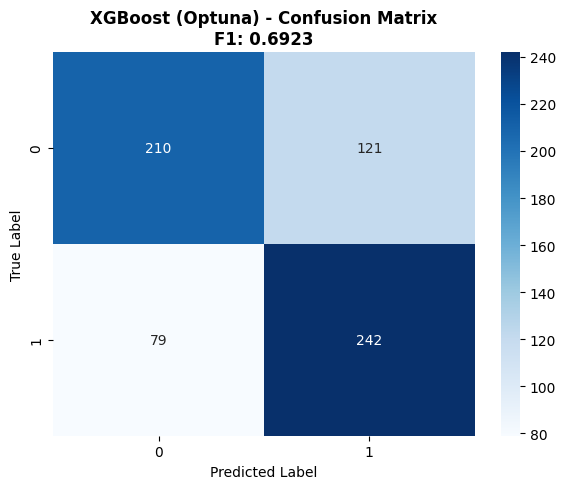

<Figure size 1000x600 with 0 Axes>

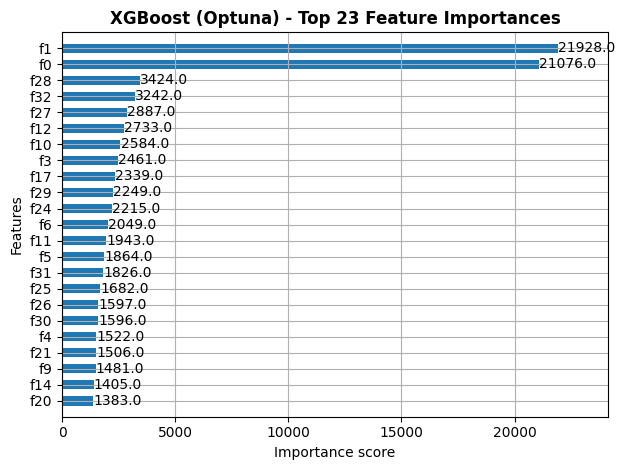

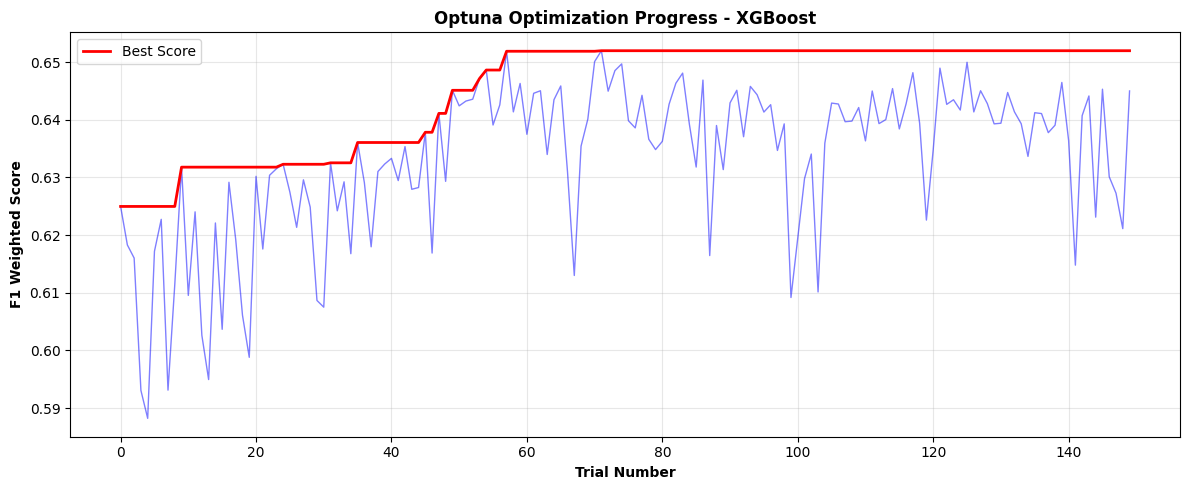


✓ XGBoost with Optuna Complete


In [43]:
# --- Objective function ---
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 1.0, log=True),
    }

    if gpu_xgb_enabled:
        params['tree_method'] = 'gpu_hist'
        params['gpu_id'] = 0
        params['predictor'] = 'gpu_predictor'

    model = xgb.XGBClassifier(
        **params,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        use_label_encoder=False,
        verbosity=0
    )

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    f1_mean = scores.mean()

    trial.report(f1_mean, step=0)
    return f1_mean

# --- Optuna study ---
print('\nInitializing Optuna study with TPE sampler...')
sampler = TPESampler(seed=42, n_startup_trials=20)
pruner = MedianPruner(n_startup_trials=10)

study = optuna.create_study(
    sampler=sampler,
    pruner=pruner,
    direction='maximize',
    study_name='xgb_optimization'
)

print('Starting Optuna optimization (150 trials - this may take 5-10 minutes)...')
study.optimize(objective, n_trials=150, n_jobs=1, show_progress_bar=True)

# --- Best trial ---
best_trial = study.best_trial
best_params = best_trial.params
print(f'\n✓ Optimization Complete!')
print(f'Best CV F1 (weighted): {best_trial.value:.4f}')
print(f'\nBest hyperparameters:')
for param_name, param_value in sorted(best_params.items()):
    print(f'  {param_name}: {param_value}')

# --- Final model ---
final_params = best_params.copy()
if gpu_xgb_enabled:
    final_params['tree_method'] = 'gpu_hist'
    final_params['gpu_id'] = 0
    final_params['predictor'] = 'gpu_predictor'
    print('✓ Using GPU acceleration (tree_method=gpu_hist, predictor=gpu_predictor)')
else:
    print('Using CPU (GPU not available)')

best_xgb = xgb.XGBClassifier(
    **final_params,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False,
    verbosity=0
)
best_xgb.fit(X_train, y_train)

print(f'✓ Final model trained on full training set ({"GPU" if gpu_xgb_enabled else "CPU"})')

# --- Calibration ---
try:
    model_xgb = CalibratedClassifierCV(best_xgb, cv='prefit', method='sigmoid')
    model_xgb.fit(X_train, y_train)
    print('✓ Probability calibration successful')
except Exception as e:
    print(f'⚠️  Calibration failed: {e}')
    model_xgb = best_xgb

# --- Threshold optimization ---
thresholds = np.linspace(0.1, 0.9, 81)
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
f1_scores_xgb = [f1_score(y_test, (y_proba_xgb >= t).astype(int)) for t in thresholds]
best_t_xgb = thresholds[int(np.argmax(f1_scores_xgb))]
y_pred_xgb = (y_proba_xgb >= best_t_xgb).astype(int)

# --- Metrics ---
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_weighted_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
f1_macro_xgb = f1_score(y_test, y_pred_xgb, average='macro')
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
pr_auc_xgb = average_precision_score(y_test, y_proba_xgb)

results['xgb'] = {
    'model': model_xgb, 'best_params': best_params,
    'threshold': best_t_xgb, 'accuracy': acc_xgb,
    'f1_weighted': f1_weighted_xgb, 'f1_macro': f1_macro_xgb,
    'roc_auc': roc_auc_xgb, 'pr_auc': pr_auc_xgb,
    'y_proba': y_proba_xgb, 'y_pred': y_pred_xgb,
    'cv_f1': best_trial.value
}

print(f'\nTest Set Metrics:')
print(f'  Accuracy: {acc_xgb:.4f}')
print(f'  F1 (weighted): {f1_weighted_xgb:.4f}')
print(f'  F1 (macro): {f1_macro_xgb:.4f}')
print(f'  ROC AUC: {roc_auc_xgb:.4f}')
print(f'  PR AUC: {pr_auc_xgb:.4f}')
print(f'  Best Threshold: {best_t_xgb:.3f}')

# --- Confusion Matrix ---
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'XGBoost (Optuna) - Confusion Matrix\nF1: {f1_weighted_xgb:.4f}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- Feature importance ---
if hasattr(best_xgb, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(best_xgb, max_num_features=23, height=0.6)
    plt.title('XGBoost (Optuna) - Top 23 Feature Importances', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Optuna progress plot ---
trials_df = study.trials_dataframe()
plt.figure(figsize=(12, 5))
plt.grid(alpha=0.3)
plt.xlabel('Trial Number', fontweight='bold')
plt.ylabel('F1 Weighted Score', fontweight='bold')
plt.plot(trials_df['number'], trials_df['value'], 'b-', alpha=0.5, linewidth=1)
plt.plot(trials_df['number'], trials_df['value'].cummax(), 'r-', linewidth=2, label='Best Score')
plt.legend()
plt.title('Optuna Optimization Progress - XGBoost', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()

print('\n✓ XGBoost with Optuna Complete')


MODEL COMPARISON & FINAL SELECTION

PERFORMANCE SUMMARY (Sorted by F1 Weighted):
 Model  Accuracy  F1_Weighted  F1_Macro  ROC_AUC   PR_AUC  Best_Threshold
   xgb  0.693252     0.692279  0.692511 0.749527 0.691649            0.10
    rf  0.688650     0.678877  0.679698 0.771080 0.715966            0.18
    et  0.679448     0.670786  0.671567 0.751880 0.700755            0.02
   ada  0.662577     0.652920  0.653767 0.724534 0.677681            0.41
logreg  0.651840     0.623948  0.625472 0.729734 0.675834            0.34
   svc  0.639571     0.619523  0.620817 0.709123 0.673236            0.01
   knn  0.599693     0.555562  0.557654 0.692229 0.634570            0.05

BEST MODEL: XGB
Accuracy: 0.6933
F1 (Weighted): 0.6923
F1 (Macro): 0.6925
ROC AUC: 0.7495
PR AUC: 0.6916
Optimal Threshold: 0.1000

✓ Best model saved to: best_model.joblib
✓ Model metrics saved to: model_metrics.csv
✓ Predictions saved to: predictions.csv


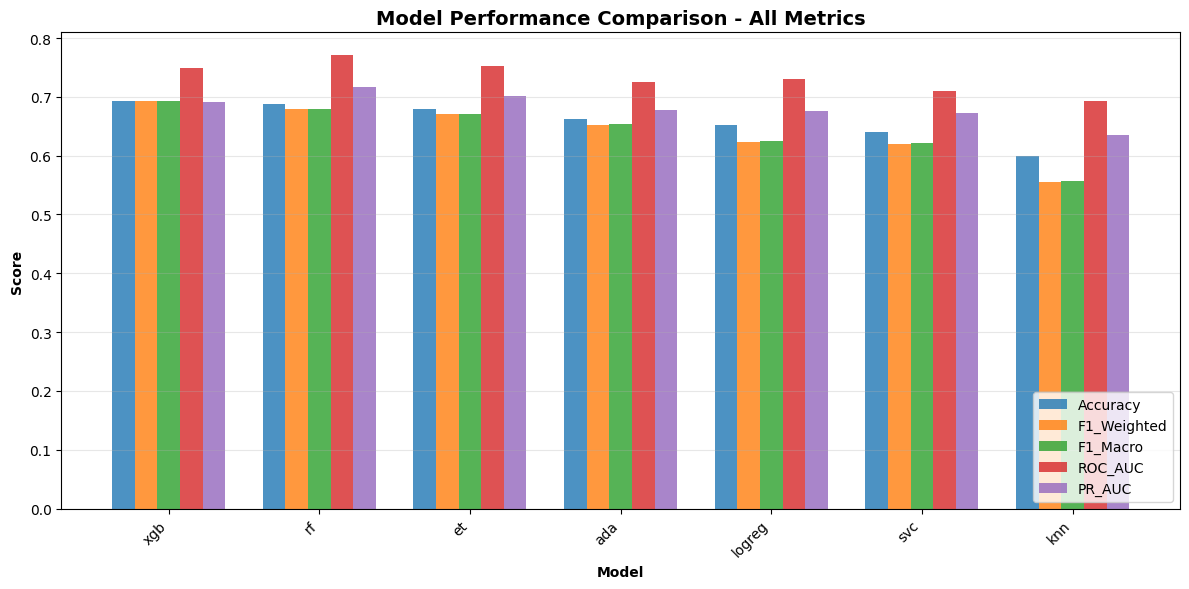


 Model Training and Evaluation Complete!


In [42]:
# Comprehensive Results Comparison and Model Selection
print('\n' + '='*60)
print('MODEL COMPARISON & FINAL SELECTION')
print('='*60)

# Create comprehensive summary
summary_data = []
for model_name, model_results in results.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': model_results.get('accuracy', np.nan),
        'F1_Weighted': model_results.get('f1_weighted', np.nan),
        'F1_Macro': model_results.get('f1_macro', np.nan),
        'ROC_AUC': model_results.get('roc_auc', np.nan),
        'PR_AUC': model_results.get('pr_auc', np.nan),
        'Best_Threshold': model_results.get('threshold', np.nan)
    })

summary_df = pd.DataFrame(summary_data).sort_values('F1_Weighted', ascending=False)

print('\n' + '='*60)
print('PERFORMANCE SUMMARY (Sorted by F1 Weighted):')
print('='*60)
print(summary_df.to_string(index=False))

# Select best model
best_model_name = summary_df.iloc[0]['Model']
best_model_results = results[best_model_name]
best_model_obj = best_model_results['model']

print('\n' + '='*60)
print(f'BEST MODEL: {best_model_name.upper()}')
print('='*60)
print(f'Accuracy: {best_model_results["accuracy"]:.4f}')
print(f'F1 (Weighted): {best_model_results["f1_weighted"]:.4f}')
print(f'F1 (Macro): {best_model_results["f1_macro"]:.4f}')
print(f'ROC AUC: {best_model_results["roc_auc"]:.4f}')
print(f'PR AUC: {best_model_results["pr_auc"]:.4f}')
print(f'Optimal Threshold: {best_model_results["threshold"]:.4f}')

# Save best model
joblib.dump(best_model_obj, os.path.join(ROOT, 'best_model.joblib'))
print(f'\n✓ Best model saved to: best_model.joblib')

# Save summary to CSV
summary_df.to_csv(os.path.join(ROOT, 'model_metrics.csv'), index=False)
print(f'✓ Model metrics saved to: model_metrics.csv')

# Save predictions from best model
pred_df = pd.DataFrame({
    'y_true': y_test,
    'y_proba': best_model_results['y_proba'],
    'y_pred': best_model_results['y_pred'],
    'model': best_model_name
})
pred_df.to_csv(os.path.join(ROOT, 'predictions.csv'), index=False)
print(f'✓ Predictions saved to: predictions.csv')

# Visualization: Model comparison
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'F1_Weighted', 'F1_Macro', 'ROC_AUC', 'PR_AUC']
x = np.arange(len(summary_df))
width = 0.15

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, summary_df[metric], width, label=metric, alpha=0.8)

plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Model Performance Comparison - All Metrics', fontweight='bold', fontsize=14)
plt.xticks(x + width*2, summary_df['Model'], rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('\n Model Training and Evaluation Complete!')